In [1]:
import copy
from functools import partial
import gc
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-05-08 08:51:41.111535: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-08 08:51:41.111567: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# generate some data
s = partial(map_to_constant, c=0.01)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="chisq", threshold=0.5,
                                  noise_distribution="chisq", noise_scale=s)
x, y = eg.generate_labeled(120096)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:9984, :], y[:9984]
x_val, y_val = x[100096:, :], y[100096:]

In [3]:
def opt_name(optimizer):
    return str(optimizer).split("object")[0].split(".")[-1].strip().lower()

optimizer_lookup = {
    opt_name(opt): opt for opt in  
    [keras.optimizers.Nadam(learning_rate=3e-5), 
     keras.optimizers.SGD(learning_rate=5e-3), 
     keras.optimizers.RMSprop(learning_rate=5e-3),
     keras.optimizers.Adam(learning_rate=3e-3),
     keras.optimizers.Adadelta(learning_rate=1e-1),
     keras.optimizers.Adamax(learning_rate=7e-3)]
}

optimal_schedules = [
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=3e-5),
        "learning_rate": 3e-5,
        "batch": 256,
        "epoch": 10*28
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 256,
        "epoch": 10*59
    },
    {
        "optimizer": keras.optimizers.SGD(learning_rate=1e-2),
        "learning_rate" :1e-2,
        "batch": 8,
        "epoch": 10*1
    },
    {
        "optimizer": keras.optimizers.RMSprop(learning_rate=5e-3),
        "learning_rate": 5e-3,
        "batch": 8,
        "epoch": 10*1# 0.1781
    },
    {
        "optimizer": keras.optimizers.Adam(learning_rate=3e-3),
        "learning_rate": 3e-3,
        "batch": 8,
        "epoch": 10*1# 0.2076
    },
    {
        "optimizer": keras.optimizers.Adadelta(learning_rate=1e-1),
        "learning_rate": 1e-1,
        "batch": 8,
        "epoch": 10*2# 0.2354
    },
    {
        "optimizer": keras.optimizers.Adamax(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*1# 0.2249
    },
    {
        "optimizer": keras.optimizers.Nadam(learning_rate=7e-3),
        "learning_rate": 7e-3,
        "batch": 8,
        "epoch": 10*4# 0.1905
    }
]

In [4]:
scan_results = []
champion_params = None
champion_loss = np.inf
for params in optimal_schedules:
    lr = params["learning_rate"]
    for learning_rate in [0.8*lr, lr, 1.2*lr]:
        optimizer = params["optimizer"]
        optimizer.learning_rate.assign(learning_rate)
        num_epochs = int(1.4*params["epoch"] + 2)
        batch_size = int(params["batch"])
        model = keras.Sequential()
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(60, activation="relu"))
        model.add(keras.layers.Dropout(0.25))
        model.add(keras.layers.Dense(1, activation="sigmoid"))
        model.compile(
            optimizer=optimizer,
            loss="binary_crossentropy",
            metrics=["accuracy", "AUC"]
        )
        history = model.fit(
            x_train,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(x_val, y_val),
        )
        
        history_dict = history.history
        val_loss = history_dict["val_loss"]
        val_auc = history_dict["val_auc"]
        val_accuracy = history_dict["val_accuracy"]
        epochs = range(1, len(val_loss)+1)
        
        best_loss = {"loss": val_loss[np.argmin(val_loss)], "epoch": epochs[np.argmin(val_loss)]}
        best_auc = {"auc": val_auc[np.argmax(val_auc)], "epoch": epochs[np.argmax(val_auc)]}
        best_accuracy = {"accuracy": val_accuracy[np.argmax(val_accuracy)], "epoch": epochs[np.argmax(val_accuracy)]}
        
        ps = {k: copy.deepcopy(v) for k, v in params.items() if k not in ["optimizer", "model"]}
        ps["optimizer"] = opt_name(optimizer)
        ps["learning_rate"] = copy.deepcopy(learning_rate)
        ps["best_loss"] = best_loss
        ps["best_auc"] = best_auc
        ps["best_accuracy"] = best_accuracy
        print(ps)
        scan_results.append(ps)
        
        if best_loss["loss"] < champion_loss:
            champion_loss = best_loss["loss"]
            champion_params = {k: copy.deepcopy(v) for k, v in ps.items()}
            champion_params["model"] = keras.models.clone_model(model)
        

model = keras.models.clone_model(champion_params["model"])

2022-05-08 08:51:50.386264: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-08 08:51:50.386464: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-08 08:51:50.386563: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-08 08:51:50.388221: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/394
39/39 [==============================] - 3s 22ms/step - loss: 0.7016 - accuracy: 0.4960 - auc: 0.4908 - val_loss: 0.6966 - val_accuracy: 0.4949 - val_auc: 0.4734
Epoch 2/394
39/39 [==============================] - 0s 9ms/step - loss: 0.6979 - accuracy: 0.4872 - auc: 0.5022 - val_loss: 0.6931 - val_accuracy: 0.4984 - val_auc: 0.5107
Epoch 3/394
39/39 [==============================] - 1s 13ms/step - loss: 0.6942 - accuracy: 0.4994 - auc: 0.5259 - val_loss: 0.6903 - val_accuracy: 0.5002 - val_auc: 0.5440
Epoch 4/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6905 - accuracy: 0.5023 - auc: 0.5434 - val_loss: 0.6879 - val_accuracy: 0.5044 - val_auc: 0.5713
Epoch 5/394
39/39 [==============================] - 0s 11ms/step - loss: 0.6871 - accuracy: 0.5057 - auc: 0.5641 - val_loss: 0.6859 - val_accuracy: 0.5083 - val_auc: 0.5956
Epoch 6/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6853 - accuracy: 0.5110 - auc: 0.5757 - val_loss: 0.6842

39/39 [==============================] - 0s 8ms/step - loss: 0.6579 - accuracy: 0.5582 - auc: 0.7200 - val_loss: 0.6545 - val_accuracy: 0.5729 - val_auc: 0.8329
Epoch 49/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6584 - accuracy: 0.5594 - auc: 0.7180 - val_loss: 0.6538 - val_accuracy: 0.5767 - val_auc: 0.8348
Epoch 50/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6580 - accuracy: 0.5610 - auc: 0.7226 - val_loss: 0.6532 - val_accuracy: 0.5802 - val_auc: 0.8362
Epoch 51/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6568 - accuracy: 0.5586 - auc: 0.7219 - val_loss: 0.6525 - val_accuracy: 0.5840 - val_auc: 0.8382
Epoch 52/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6567 - accuracy: 0.5661 - auc: 0.7198 - val_loss: 0.6518 - val_accuracy: 0.5863 - val_auc: 0.8403
Epoch 53/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6561 - accuracy: 0.5623 - auc: 0.7231 - val_loss: 0.6511 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.6190 - accuracy: 0.6608 - auc: 0.7836 - val_loss: 0.6061 - val_accuracy: 0.7655 - val_auc: 0.8999
Epoch 96/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6152 - accuracy: 0.6639 - auc: 0.7898 - val_loss: 0.6046 - val_accuracy: 0.7699 - val_auc: 0.9010
Epoch 97/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6155 - accuracy: 0.6673 - auc: 0.7894 - val_loss: 0.6031 - val_accuracy: 0.7753 - val_auc: 0.9019
Epoch 98/394
39/39 [==============================] - 0s 12ms/step - loss: 0.6127 - accuracy: 0.6702 - auc: 0.7931 - val_loss: 0.6015 - val_accuracy: 0.7789 - val_auc: 0.9030
Epoch 99/394
39/39 [==============================] - 1s 14ms/step - loss: 0.6121 - accuracy: 0.6763 - auc: 0.7922 - val_loss: 0.5999 - val_accuracy: 0.7829 - val_auc: 0.9047
Epoch 100/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6111 - accuracy: 0.6737 - auc: 0.7933 - val_loss: 0.5983 - val_a

Epoch 142/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5445 - accuracy: 0.7473 - auc: 0.8416 - val_loss: 0.5152 - val_accuracy: 0.8651 - val_auc: 0.9466
Epoch 143/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5415 - accuracy: 0.7479 - auc: 0.8436 - val_loss: 0.5129 - val_accuracy: 0.8658 - val_auc: 0.9474
Epoch 144/394
39/39 [==============================] - 0s 12ms/step - loss: 0.5426 - accuracy: 0.7491 - auc: 0.8415 - val_loss: 0.5110 - val_accuracy: 0.8669 - val_auc: 0.9482
Epoch 145/394
39/39 [==============================] - 0s 6ms/step - loss: 0.5436 - accuracy: 0.7442 - auc: 0.8371 - val_loss: 0.5087 - val_accuracy: 0.8679 - val_auc: 0.9488
Epoch 146/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5387 - accuracy: 0.7499 - auc: 0.8439 - val_loss: 0.5062 - val_accuracy: 0.8694 - val_auc: 0.9496
Epoch 147/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5372 - accuracy: 0.7516 - auc: 0.8450 - val_los

Epoch 189/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4572 - accuracy: 0.7998 - auc: 0.8869 - val_loss: 0.4118 - val_accuracy: 0.8909 - val_auc: 0.9721
Epoch 190/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4612 - accuracy: 0.7983 - auc: 0.8833 - val_loss: 0.4086 - val_accuracy: 0.8928 - val_auc: 0.9724
Epoch 191/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4652 - accuracy: 0.7887 - auc: 0.8784 - val_loss: 0.4074 - val_accuracy: 0.8920 - val_auc: 0.9728
Epoch 192/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4617 - accuracy: 0.7936 - auc: 0.8813 - val_loss: 0.4046 - val_accuracy: 0.8938 - val_auc: 0.9732
Epoch 193/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4566 - accuracy: 0.7994 - auc: 0.8849 - val_loss: 0.4027 - val_accuracy: 0.8932 - val_auc: 0.9734
Epoch 194/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4613 - accuracy: 0.7916 - auc: 0.8798 - val_los

Epoch 236/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4016 - accuracy: 0.8223 - auc: 0.9069 - val_loss: 0.3330 - val_accuracy: 0.8968 - val_auc: 0.9837
Epoch 237/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3980 - accuracy: 0.8220 - auc: 0.9084 - val_loss: 0.3303 - val_accuracy: 0.8990 - val_auc: 0.9839
Epoch 238/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3979 - accuracy: 0.8192 - auc: 0.9085 - val_loss: 0.3286 - val_accuracy: 0.9003 - val_auc: 0.9841
Epoch 239/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4029 - accuracy: 0.8185 - auc: 0.9051 - val_loss: 0.3283 - val_accuracy: 0.8989 - val_auc: 0.9841
Epoch 240/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3983 - accuracy: 0.8220 - auc: 0.9072 - val_loss: 0.3261 - val_accuracy: 0.9007 - val_auc: 0.9843
Epoch 241/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3959 - accuracy: 0.8208 - auc: 0.9092 - val_loss

Epoch 283/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3658 - accuracy: 0.8348 - auc: 0.9201 - val_loss: 0.2862 - val_accuracy: 0.8990 - val_auc: 0.9890
Epoch 284/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3645 - accuracy: 0.8330 - auc: 0.9204 - val_loss: 0.2872 - val_accuracy: 0.8959 - val_auc: 0.9890
Epoch 285/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3635 - accuracy: 0.8370 - auc: 0.9206 - val_loss: 0.2867 - val_accuracy: 0.8954 - val_auc: 0.9891
Epoch 286/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3539 - accuracy: 0.8419 - auc: 0.9258 - val_loss: 0.2852 - val_accuracy: 0.8965 - val_auc: 0.9892
Epoch 287/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3585 - accuracy: 0.8400 - auc: 0.9237 - val_loss: 0.2849 - val_accuracy: 0.8961 - val_auc: 0.9892
Epoch 288/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3616 - accuracy: 0.8377 - auc: 0.9207 - val_los

Epoch 330/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8526 - auc: 0.9312 - val_loss: 0.2635 - val_accuracy: 0.8931 - val_auc: 0.9914
Epoch 331/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3337 - accuracy: 0.8480 - auc: 0.9325 - val_loss: 0.2648 - val_accuracy: 0.8910 - val_auc: 0.9914
Epoch 332/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3442 - accuracy: 0.8452 - auc: 0.9274 - val_loss: 0.2637 - val_accuracy: 0.8921 - val_auc: 0.9915
Epoch 333/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3301 - accuracy: 0.8516 - auc: 0.9342 - val_loss: 0.2639 - val_accuracy: 0.8913 - val_auc: 0.9915
Epoch 334/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3334 - accuracy: 0.8525 - auc: 0.9330 - val_loss: 0.2648 - val_accuracy: 0.8896 - val_auc: 0.9915
Epoch 335/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3387 - accuracy: 0.8501 - auc: 0.9298 - val_loss

Epoch 377/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3118 - accuracy: 0.8654 - auc: 0.9410 - val_loss: 0.2546 - val_accuracy: 0.8847 - val_auc: 0.9925
Epoch 378/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3152 - accuracy: 0.8602 - auc: 0.9393 - val_loss: 0.2522 - val_accuracy: 0.8878 - val_auc: 0.9926
Epoch 379/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3122 - accuracy: 0.8625 - auc: 0.9406 - val_loss: 0.2550 - val_accuracy: 0.8840 - val_auc: 0.9926
Epoch 380/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3116 - accuracy: 0.8610 - auc: 0.9407 - val_loss: 0.2537 - val_accuracy: 0.8854 - val_auc: 0.9926
Epoch 381/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3189 - accuracy: 0.8584 - auc: 0.9379 - val_loss: 0.2530 - val_accuracy: 0.8863 - val_auc: 0.9925
Epoch 382/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3122 - accuracy: 0.8593 - auc: 0.9403 - val_loss

39/39 [==============================] - 0s 5ms/step - loss: 0.6433 - accuracy: 0.6023 - auc: 0.7466 - val_loss: 0.6368 - val_accuracy: 0.6531 - val_auc: 0.8696
Epoch 29/394
39/39 [==============================] - 0s 5ms/step - loss: 0.6418 - accuracy: 0.6061 - auc: 0.7512 - val_loss: 0.6352 - val_accuracy: 0.6572 - val_auc: 0.8718
Epoch 30/394
39/39 [==============================] - 0s 5ms/step - loss: 0.6421 - accuracy: 0.6098 - auc: 0.7458 - val_loss: 0.6337 - val_accuracy: 0.6660 - val_auc: 0.8738
Epoch 31/394
39/39 [==============================] - 0s 5ms/step - loss: 0.6386 - accuracy: 0.6137 - auc: 0.7554 - val_loss: 0.6320 - val_accuracy: 0.6714 - val_auc: 0.8758
Epoch 32/394
39/39 [==============================] - 0s 5ms/step - loss: 0.6370 - accuracy: 0.6217 - auc: 0.7609 - val_loss: 0.6303 - val_accuracy: 0.6773 - val_auc: 0.8781
Epoch 33/394
39/39 [==============================] - 0s 5ms/step - loss: 0.6371 - accuracy: 0.6171 - auc: 0.7579 - val_loss: 0.6287 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.5588 - accuracy: 0.7352 - auc: 0.8263 - val_loss: 0.5269 - val_accuracy: 0.8634 - val_auc: 0.9412
Epoch 76/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5527 - accuracy: 0.7410 - auc: 0.8331 - val_loss: 0.5241 - val_accuracy: 0.8649 - val_auc: 0.9423
Epoch 77/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5520 - accuracy: 0.7362 - auc: 0.8313 - val_loss: 0.5210 - val_accuracy: 0.8665 - val_auc: 0.9439
Epoch 78/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5471 - accuracy: 0.7418 - auc: 0.8372 - val_loss: 0.5180 - val_accuracy: 0.8682 - val_auc: 0.9452
Epoch 79/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5420 - accuracy: 0.7467 - auc: 0.8408 - val_loss: 0.5148 - val_accuracy: 0.8692 - val_auc: 0.9461
Epoch 80/394
39/39 [==============================] - 0s 7ms/step - loss: 0.5461 - accuracy: 0.7452 - auc: 0.8343 - val_loss: 0.5119 - val_accu

39/39 [==============================] - 0s 8ms/step - loss: 0.4502 - accuracy: 0.8019 - auc: 0.8875 - val_loss: 0.3947 - val_accuracy: 0.8913 - val_auc: 0.9734
Epoch 123/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4414 - accuracy: 0.8070 - auc: 0.8945 - val_loss: 0.3923 - val_accuracy: 0.8914 - val_auc: 0.9738
Epoch 124/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4544 - accuracy: 0.7924 - auc: 0.8805 - val_loss: 0.3908 - val_accuracy: 0.8900 - val_auc: 0.9742
Epoch 125/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4437 - accuracy: 0.8067 - auc: 0.8893 - val_loss: 0.3883 - val_accuracy: 0.8905 - val_auc: 0.9745
Epoch 126/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4474 - accuracy: 0.7975 - auc: 0.8853 - val_loss: 0.3841 - val_accuracy: 0.8944 - val_auc: 0.9748
Epoch 127/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4417 - accuracy: 0.8018 - auc: 0.8895 - val_loss: 0.3820 - val

Epoch 169/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3765 - accuracy: 0.8287 - auc: 0.9173 - val_loss: 0.3110 - val_accuracy: 0.8941 - val_auc: 0.9843
Epoch 170/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3806 - accuracy: 0.8313 - auc: 0.9144 - val_loss: 0.3085 - val_accuracy: 0.8960 - val_auc: 0.9844
Epoch 171/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3780 - accuracy: 0.8273 - auc: 0.9152 - val_loss: 0.3090 - val_accuracy: 0.8932 - val_auc: 0.9846
Epoch 172/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3736 - accuracy: 0.8320 - auc: 0.9180 - val_loss: 0.3061 - val_accuracy: 0.8956 - val_auc: 0.9847
Epoch 173/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3776 - accuracy: 0.8324 - auc: 0.9155 - val_loss: 0.3060 - val_accuracy: 0.8942 - val_auc: 0.9849
Epoch 174/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3727 - accuracy: 0.8323 - auc: 0.9179 - val_loss

Epoch 216/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3315 - accuracy: 0.8550 - auc: 0.9350 - val_loss: 0.2722 - val_accuracy: 0.8906 - val_auc: 0.9884
Epoch 217/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3404 - accuracy: 0.8467 - auc: 0.9298 - val_loss: 0.2708 - val_accuracy: 0.8913 - val_auc: 0.9885
Epoch 218/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3371 - accuracy: 0.8492 - auc: 0.9317 - val_loss: 0.2695 - val_accuracy: 0.8924 - val_auc: 0.9886
Epoch 219/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3353 - accuracy: 0.8533 - auc: 0.9323 - val_loss: 0.2674 - val_accuracy: 0.8941 - val_auc: 0.9887
Epoch 220/394
39/39 [==============================] - 0s 12ms/step - loss: 0.3347 - accuracy: 0.8534 - auc: 0.9330 - val_loss: 0.2706 - val_accuracy: 0.8898 - val_auc: 0.9887
Epoch 221/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3399 - accuracy: 0.8510 - auc: 0.9298 - val_los

Epoch 263/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3145 - accuracy: 0.8589 - auc: 0.9398 - val_loss: 0.2574 - val_accuracy: 0.8835 - val_auc: 0.9906
Epoch 264/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3105 - accuracy: 0.8635 - auc: 0.9413 - val_loss: 0.2582 - val_accuracy: 0.8825 - val_auc: 0.9906
Epoch 265/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3148 - accuracy: 0.8585 - auc: 0.9391 - val_loss: 0.2547 - val_accuracy: 0.8859 - val_auc: 0.9906
Epoch 266/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3148 - accuracy: 0.8574 - auc: 0.9391 - val_loss: 0.2570 - val_accuracy: 0.8829 - val_auc: 0.9906
Epoch 267/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3108 - accuracy: 0.8627 - auc: 0.9415 - val_loss: 0.2581 - val_accuracy: 0.8820 - val_auc: 0.9906
Epoch 268/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3054 - accuracy: 0.8648 - auc: 0.9434 - val_loss

Epoch 310/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2987 - accuracy: 0.8659 - auc: 0.9455 - val_loss: 0.2579 - val_accuracy: 0.8731 - val_auc: 0.9913
Epoch 311/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3027 - accuracy: 0.8613 - auc: 0.9435 - val_loss: 0.2579 - val_accuracy: 0.8733 - val_auc: 0.9913
Epoch 312/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3003 - accuracy: 0.8651 - auc: 0.9448 - val_loss: 0.2591 - val_accuracy: 0.8721 - val_auc: 0.9912
Epoch 313/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2966 - accuracy: 0.8701 - auc: 0.9460 - val_loss: 0.2588 - val_accuracy: 0.8723 - val_auc: 0.9913
Epoch 314/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2906 - accuracy: 0.8732 - auc: 0.9484 - val_loss: 0.2566 - val_accuracy: 0.8735 - val_auc: 0.9913
Epoch 315/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2918 - accuracy: 0.8683 - auc: 0.9485 - val_loss

Epoch 357/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2839 - accuracy: 0.8726 - auc: 0.9508 - val_loss: 0.2622 - val_accuracy: 0.8655 - val_auc: 0.9916
Epoch 358/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2799 - accuracy: 0.8762 - auc: 0.9519 - val_loss: 0.2637 - val_accuracy: 0.8647 - val_auc: 0.9916
Epoch 359/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2837 - accuracy: 0.8740 - auc: 0.9511 - val_loss: 0.2639 - val_accuracy: 0.8644 - val_auc: 0.9917
Epoch 360/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2813 - accuracy: 0.8766 - auc: 0.9516 - val_loss: 0.2636 - val_accuracy: 0.8647 - val_auc: 0.9916
Epoch 361/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2841 - accuracy: 0.8701 - auc: 0.9506 - val_loss: 0.2627 - val_accuracy: 0.8651 - val_auc: 0.9917
Epoch 362/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2861 - accuracy: 0.8742 - auc: 0.9495 - val_loss

39/39 [==============================] - 0s 8ms/step - loss: 0.6658 - accuracy: 0.5436 - auc: 0.6861 - val_loss: 0.6568 - val_accuracy: 0.5343 - val_auc: 0.8479
Epoch 9/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6637 - accuracy: 0.5492 - auc: 0.6954 - val_loss: 0.6551 - val_accuracy: 0.5404 - val_auc: 0.8527
Epoch 10/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6582 - accuracy: 0.5579 - auc: 0.7119 - val_loss: 0.6534 - val_accuracy: 0.5476 - val_auc: 0.8560
Epoch 11/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6602 - accuracy: 0.5571 - auc: 0.6973 - val_loss: 0.6518 - val_accuracy: 0.5574 - val_auc: 0.8583
Epoch 12/394
39/39 [==============================] - 0s 7ms/step - loss: 0.6568 - accuracy: 0.5628 - auc: 0.7169 - val_loss: 0.6500 - val_accuracy: 0.5627 - val_auc: 0.8620
Epoch 13/394
39/39 [==============================] - 0s 8ms/step - loss: 0.6548 - accuracy: 0.5684 - auc: 0.7234 - val_loss: 0.6484 - val_accur

39/39 [==============================] - 0s 8ms/step - loss: 0.5642 - accuracy: 0.7298 - auc: 0.8300 - val_loss: 0.5414 - val_accuracy: 0.8396 - val_auc: 0.9298
Epoch 56/394
39/39 [==============================] - 1s 15ms/step - loss: 0.5618 - accuracy: 0.7306 - auc: 0.8319 - val_loss: 0.5375 - val_accuracy: 0.8414 - val_auc: 0.9309
Epoch 57/394
39/39 [==============================] - 0s 8ms/step - loss: 0.5559 - accuracy: 0.7415 - auc: 0.8388 - val_loss: 0.5331 - val_accuracy: 0.8438 - val_auc: 0.9327
Epoch 58/394
39/39 [==============================] - 0s 11ms/step - loss: 0.5569 - accuracy: 0.7326 - auc: 0.8321 - val_loss: 0.5299 - val_accuracy: 0.8476 - val_auc: 0.9335
Epoch 59/394
39/39 [==============================] - 0s 9ms/step - loss: 0.5538 - accuracy: 0.7364 - auc: 0.8358 - val_loss: 0.5267 - val_accuracy: 0.8505 - val_auc: 0.9349
Epoch 60/394
39/39 [==============================] - 0s 11ms/step - loss: 0.5511 - accuracy: 0.7438 - auc: 0.8359 - val_loss: 0.5228 - val_a

39/39 [==============================] - 0s 7ms/step - loss: 0.4285 - accuracy: 0.8124 - auc: 0.8981 - val_loss: 0.3737 - val_accuracy: 0.8874 - val_auc: 0.9712
Epoch 103/394
39/39 [==============================] - 0s 7ms/step - loss: 0.4290 - accuracy: 0.8071 - auc: 0.8952 - val_loss: 0.3712 - val_accuracy: 0.8878 - val_auc: 0.9716
Epoch 104/394
39/39 [==============================] - 0s 12ms/step - loss: 0.4315 - accuracy: 0.8046 - auc: 0.8929 - val_loss: 0.3669 - val_accuracy: 0.8907 - val_auc: 0.9722
Epoch 105/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4231 - accuracy: 0.8126 - auc: 0.8991 - val_loss: 0.3647 - val_accuracy: 0.8906 - val_auc: 0.9728
Epoch 106/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4221 - accuracy: 0.8127 - auc: 0.8988 - val_loss: 0.3628 - val_accuracy: 0.8896 - val_auc: 0.9732
Epoch 107/394
39/39 [==============================] - 0s 8ms/step - loss: 0.4187 - accuracy: 0.8132 - auc: 0.9010 - val_loss: 0.3604 - va

Epoch 149/394
39/39 [==============================] - 0s 9ms/step - loss: 0.3531 - accuracy: 0.8414 - auc: 0.9260 - val_loss: 0.2900 - val_accuracy: 0.8913 - val_auc: 0.9851
Epoch 150/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3535 - accuracy: 0.8402 - auc: 0.9253 - val_loss: 0.2883 - val_accuracy: 0.8917 - val_auc: 0.9852
Epoch 151/394
39/39 [==============================] - 0s 6ms/step - loss: 0.3456 - accuracy: 0.8453 - auc: 0.9297 - val_loss: 0.2841 - val_accuracy: 0.8957 - val_auc: 0.9854
Epoch 152/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3568 - accuracy: 0.8387 - auc: 0.9236 - val_loss: 0.2867 - val_accuracy: 0.8913 - val_auc: 0.9856
Epoch 153/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3463 - accuracy: 0.8463 - auc: 0.9286 - val_loss: 0.2846 - val_accuracy: 0.8921 - val_auc: 0.9857
Epoch 154/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3470 - accuracy: 0.8439 - auc: 0.9280 - val_loss

Epoch 196/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3182 - accuracy: 0.8562 - auc: 0.9384 - val_loss: 0.2581 - val_accuracy: 0.8879 - val_auc: 0.9891
Epoch 197/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3067 - accuracy: 0.8656 - auc: 0.9432 - val_loss: 0.2607 - val_accuracy: 0.8838 - val_auc: 0.9891
Epoch 198/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3103 - accuracy: 0.8616 - auc: 0.9416 - val_loss: 0.2628 - val_accuracy: 0.8810 - val_auc: 0.9892
Epoch 199/394
39/39 [==============================] - 0s 8ms/step - loss: 0.3109 - accuracy: 0.8623 - auc: 0.9416 - val_loss: 0.2615 - val_accuracy: 0.8824 - val_auc: 0.9892
Epoch 200/394
39/39 [==============================] - 1s 13ms/step - loss: 0.3070 - accuracy: 0.8658 - auc: 0.9435 - val_loss: 0.2601 - val_accuracy: 0.8830 - val_auc: 0.9893
Epoch 201/394
39/39 [==============================] - 0s 7ms/step - loss: 0.3038 - accuracy: 0.8656 - auc: 0.9443 - val_los

Epoch 243/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2882 - accuracy: 0.8734 - auc: 0.9492 - val_loss: 0.2590 - val_accuracy: 0.8719 - val_auc: 0.9907
Epoch 244/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2890 - accuracy: 0.8734 - auc: 0.9491 - val_loss: 0.2582 - val_accuracy: 0.8723 - val_auc: 0.9907
Epoch 245/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2953 - accuracy: 0.8682 - auc: 0.9465 - val_loss: 0.2606 - val_accuracy: 0.8702 - val_auc: 0.9907
Epoch 246/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2881 - accuracy: 0.8690 - auc: 0.9493 - val_loss: 0.2540 - val_accuracy: 0.8763 - val_auc: 0.9907
Epoch 247/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2926 - accuracy: 0.8711 - auc: 0.9478 - val_loss: 0.2593 - val_accuracy: 0.8714 - val_auc: 0.9908
Epoch 248/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2794 - accuracy: 0.8791 - auc: 0.9530 - val_los

Epoch 290/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2840 - accuracy: 0.8753 - auc: 0.9507 - val_loss: 0.2648 - val_accuracy: 0.8627 - val_auc: 0.9915
Epoch 291/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2712 - accuracy: 0.8809 - auc: 0.9550 - val_loss: 0.2655 - val_accuracy: 0.8626 - val_auc: 0.9915
Epoch 292/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2751 - accuracy: 0.8786 - auc: 0.9534 - val_loss: 0.2682 - val_accuracy: 0.8604 - val_auc: 0.9915
Epoch 293/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2758 - accuracy: 0.8751 - auc: 0.9532 - val_loss: 0.2667 - val_accuracy: 0.8614 - val_auc: 0.9915
Epoch 294/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2722 - accuracy: 0.8798 - auc: 0.9544 - val_loss: 0.2678 - val_accuracy: 0.8609 - val_auc: 0.9915
Epoch 295/394
39/39 [==============================] - 0s 12ms/step - loss: 0.2672 - accuracy: 0.8836 - auc: 0.9567 - val_los

Epoch 337/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2601 - accuracy: 0.8857 - auc: 0.9591 - val_loss: 0.2829 - val_accuracy: 0.8504 - val_auc: 0.9918
Epoch 338/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2582 - accuracy: 0.8872 - auc: 0.9594 - val_loss: 0.2846 - val_accuracy: 0.8490 - val_auc: 0.9918
Epoch 339/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2620 - accuracy: 0.8844 - auc: 0.9581 - val_loss: 0.2825 - val_accuracy: 0.8504 - val_auc: 0.9919
Epoch 340/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2626 - accuracy: 0.8849 - auc: 0.9577 - val_loss: 0.2874 - val_accuracy: 0.8471 - val_auc: 0.9919
Epoch 341/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2619 - accuracy: 0.8816 - auc: 0.9580 - val_loss: 0.2824 - val_accuracy: 0.8499 - val_auc: 0.9919
Epoch 342/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2632 - accuracy: 0.8856 - auc: 0.9571 - val_loss

Epoch 384/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2568 - accuracy: 0.8852 - auc: 0.9592 - val_loss: 0.2967 - val_accuracy: 0.8425 - val_auc: 0.9920
Epoch 385/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2519 - accuracy: 0.8884 - auc: 0.9609 - val_loss: 0.2981 - val_accuracy: 0.8417 - val_auc: 0.9920
Epoch 386/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2472 - accuracy: 0.8924 - auc: 0.9626 - val_loss: 0.2992 - val_accuracy: 0.8410 - val_auc: 0.9919
Epoch 387/394
39/39 [==============================] - 0s 7ms/step - loss: 0.2531 - accuracy: 0.8888 - auc: 0.9606 - val_loss: 0.2987 - val_accuracy: 0.8414 - val_auc: 0.9920
Epoch 388/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2498 - accuracy: 0.8906 - auc: 0.9622 - val_loss: 0.2996 - val_accuracy: 0.8411 - val_auc: 0.9920
Epoch 389/394
39/39 [==============================] - 0s 8ms/step - loss: 0.2589 - accuracy: 0.8877 - auc: 0.9584 - val_loss

39/39 [==============================] - 0s 8ms/step - loss: 0.6605 - accuracy: 0.5947 - auc: 0.6754 - val_loss: 0.6500 - val_accuracy: 0.6766 - val_auc: 0.8152
Epoch 36/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6582 - accuracy: 0.5964 - auc: 0.6806 - val_loss: 0.6489 - val_accuracy: 0.6831 - val_auc: 0.8190
Epoch 37/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6541 - accuracy: 0.6072 - auc: 0.6914 - val_loss: 0.6479 - val_accuracy: 0.6895 - val_auc: 0.8220
Epoch 38/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6550 - accuracy: 0.5965 - auc: 0.6880 - val_loss: 0.6468 - val_accuracy: 0.6956 - val_auc: 0.8251
Epoch 39/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6545 - accuracy: 0.6077 - auc: 0.6934 - val_loss: 0.6458 - val_accuracy: 0.7024 - val_auc: 0.8285
Epoch 40/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6531 - accuracy: 0.6072 - auc: 0.6983 - val_loss: 0.6447 - val_accu

39/39 [==============================] - 0s 6ms/step - loss: 0.6085 - accuracy: 0.6935 - auc: 0.7762 - val_loss: 0.5961 - val_accuracy: 0.8209 - val_auc: 0.9073
Epoch 83/828
39/39 [==============================] - 0s 5ms/step - loss: 0.6031 - accuracy: 0.6975 - auc: 0.7868 - val_loss: 0.5948 - val_accuracy: 0.8225 - val_auc: 0.9083
Epoch 84/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6031 - accuracy: 0.6971 - auc: 0.7848 - val_loss: 0.5936 - val_accuracy: 0.8226 - val_auc: 0.9096
Epoch 85/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6043 - accuracy: 0.6963 - auc: 0.7809 - val_loss: 0.5924 - val_accuracy: 0.8234 - val_auc: 0.9108
Epoch 86/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6006 - accuracy: 0.7003 - auc: 0.7851 - val_loss: 0.5912 - val_accuracy: 0.8249 - val_auc: 0.9118
Epoch 87/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6017 - accuracy: 0.6985 - auc: 0.7825 - val_loss: 0.5898 - val_accu

Epoch 129/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5472 - accuracy: 0.7504 - auc: 0.8347 - val_loss: 0.5278 - val_accuracy: 0.8547 - val_auc: 0.9487
Epoch 130/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5436 - accuracy: 0.7506 - auc: 0.8387 - val_loss: 0.5259 - val_accuracy: 0.8558 - val_auc: 0.9493
Epoch 131/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5441 - accuracy: 0.7512 - auc: 0.8367 - val_loss: 0.5245 - val_accuracy: 0.8554 - val_auc: 0.9499
Epoch 132/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5462 - accuracy: 0.7416 - auc: 0.8325 - val_loss: 0.5229 - val_accuracy: 0.8559 - val_auc: 0.9505
Epoch 133/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5399 - accuracy: 0.7578 - auc: 0.8407 - val_loss: 0.5213 - val_accuracy: 0.8562 - val_auc: 0.9510
Epoch 134/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5394 - accuracy: 0.7565 - auc: 0.8420 - val_loss

Epoch 176/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4859 - accuracy: 0.7792 - auc: 0.8690 - val_loss: 0.4497 - val_accuracy: 0.8666 - val_auc: 0.9698
Epoch 177/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4788 - accuracy: 0.7904 - auc: 0.8775 - val_loss: 0.4477 - val_accuracy: 0.8674 - val_auc: 0.9702
Epoch 178/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4800 - accuracy: 0.7868 - auc: 0.8745 - val_loss: 0.4456 - val_accuracy: 0.8690 - val_auc: 0.9705
Epoch 179/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4843 - accuracy: 0.7793 - auc: 0.8675 - val_loss: 0.4441 - val_accuracy: 0.8691 - val_auc: 0.9709
Epoch 180/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4760 - accuracy: 0.7931 - auc: 0.8765 - val_loss: 0.4426 - val_accuracy: 0.8694 - val_auc: 0.9712
Epoch 181/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4786 - accuracy: 0.7886 - auc: 0.8734 - val_loss

Epoch 223/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4303 - accuracy: 0.8053 - auc: 0.8956 - val_loss: 0.3790 - val_accuracy: 0.8766 - val_auc: 0.9817
Epoch 224/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4304 - accuracy: 0.8060 - auc: 0.8944 - val_loss: 0.3778 - val_accuracy: 0.8763 - val_auc: 0.9818
Epoch 225/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4217 - accuracy: 0.8167 - auc: 0.9015 - val_loss: 0.3765 - val_accuracy: 0.8763 - val_auc: 0.9820
Epoch 226/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4204 - accuracy: 0.8151 - auc: 0.9030 - val_loss: 0.3740 - val_accuracy: 0.8781 - val_auc: 0.9822
Epoch 227/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4247 - accuracy: 0.8098 - auc: 0.8985 - val_loss: 0.3727 - val_accuracy: 0.8781 - val_auc: 0.9824
Epoch 228/828
39/39 [==============================] - 0s 6ms/step - loss: 0.4182 - accuracy: 0.8185 - auc: 0.9036 - val_loss

Epoch 270/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3869 - accuracy: 0.8267 - auc: 0.9139 - val_loss: 0.3230 - val_accuracy: 0.8863 - val_auc: 0.9877
Epoch 271/828
39/39 [==============================] - 1s 13ms/step - loss: 0.3811 - accuracy: 0.8292 - auc: 0.9168 - val_loss: 0.3207 - val_accuracy: 0.8887 - val_auc: 0.9878
Epoch 272/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3793 - accuracy: 0.8299 - auc: 0.9183 - val_loss: 0.3200 - val_accuracy: 0.8885 - val_auc: 0.9879
Epoch 273/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3763 - accuracy: 0.8366 - auc: 0.9202 - val_loss: 0.3204 - val_accuracy: 0.8864 - val_auc: 0.9880
Epoch 274/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3791 - accuracy: 0.8325 - auc: 0.9181 - val_loss: 0.3190 - val_accuracy: 0.8874 - val_auc: 0.9881
Epoch 275/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3777 - accuracy: 0.8339 - auc: 0.9186 - val_l

Epoch 317/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3519 - accuracy: 0.8472 - auc: 0.9280 - val_loss: 0.2870 - val_accuracy: 0.8913 - val_auc: 0.9904
Epoch 318/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3529 - accuracy: 0.8414 - auc: 0.9279 - val_loss: 0.2861 - val_accuracy: 0.8918 - val_auc: 0.9904
Epoch 319/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3475 - accuracy: 0.8466 - auc: 0.9307 - val_loss: 0.2852 - val_accuracy: 0.8924 - val_auc: 0.9904
Epoch 320/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3510 - accuracy: 0.8443 - auc: 0.9284 - val_loss: 0.2849 - val_accuracy: 0.8922 - val_auc: 0.9905
Epoch 321/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3496 - accuracy: 0.8463 - auc: 0.9287 - val_loss: 0.2842 - val_accuracy: 0.8923 - val_auc: 0.9905
Epoch 322/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3471 - accuracy: 0.8493 - auc: 0.9303 - val_

Epoch 364/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3258 - accuracy: 0.8612 - auc: 0.9380 - val_loss: 0.2640 - val_accuracy: 0.8938 - val_auc: 0.9915
Epoch 365/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3335 - accuracy: 0.8504 - auc: 0.9340 - val_loss: 0.2643 - val_accuracy: 0.8928 - val_auc: 0.9915
Epoch 366/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3298 - accuracy: 0.8534 - auc: 0.9369 - val_loss: 0.2636 - val_accuracy: 0.8933 - val_auc: 0.9916
Epoch 367/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3296 - accuracy: 0.8546 - auc: 0.9363 - val_loss: 0.2644 - val_accuracy: 0.8921 - val_auc: 0.9916
Epoch 368/828
39/39 [==============================] - 0s 11ms/step - loss: 0.3257 - accuracy: 0.8564 - auc: 0.9381 - val_loss: 0.2631 - val_accuracy: 0.8934 - val_auc: 0.9916
Epoch 369/828
39/39 [==============================] - 0s 10ms/step - loss: 0.3310 - accuracy: 0.8525 - auc: 0.9355 - val_l

Epoch 411/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3117 - accuracy: 0.8611 - auc: 0.9425 - val_loss: 0.2510 - val_accuracy: 0.8930 - val_auc: 0.9921
Epoch 412/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3156 - accuracy: 0.8610 - auc: 0.9410 - val_loss: 0.2497 - val_accuracy: 0.8944 - val_auc: 0.9921
Epoch 413/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3136 - accuracy: 0.8615 - auc: 0.9423 - val_loss: 0.2514 - val_accuracy: 0.8926 - val_auc: 0.9922
Epoch 414/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3133 - accuracy: 0.8626 - auc: 0.9426 - val_loss: 0.2498 - val_accuracy: 0.8936 - val_auc: 0.9922
Epoch 415/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3099 - accuracy: 0.8638 - auc: 0.9435 - val_loss: 0.2520 - val_accuracy: 0.8917 - val_auc: 0.9922
Epoch 416/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3069 - accuracy: 0.8660 - auc: 0.9446 - val_los

Epoch 458/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3032 - accuracy: 0.8643 - auc: 0.9453 - val_loss: 0.2422 - val_accuracy: 0.8936 - val_auc: 0.9926
Epoch 459/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2942 - accuracy: 0.8706 - auc: 0.9492 - val_loss: 0.2433 - val_accuracy: 0.8924 - val_auc: 0.9926
Epoch 460/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3006 - accuracy: 0.8663 - auc: 0.9463 - val_loss: 0.2445 - val_accuracy: 0.8910 - val_auc: 0.9926
Epoch 461/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3012 - accuracy: 0.8680 - auc: 0.9466 - val_loss: 0.2433 - val_accuracy: 0.8923 - val_auc: 0.9926
Epoch 462/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3025 - accuracy: 0.8695 - auc: 0.9457 - val_loss: 0.2392 - val_accuracy: 0.8960 - val_auc: 0.9926
Epoch 463/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2967 - accuracy: 0.8713 - auc: 0.9479 - val_lo

Epoch 505/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2902 - accuracy: 0.8764 - auc: 0.9496 - val_loss: 0.2371 - val_accuracy: 0.8925 - val_auc: 0.9929
Epoch 506/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2846 - accuracy: 0.8769 - auc: 0.9518 - val_loss: 0.2401 - val_accuracy: 0.8899 - val_auc: 0.9930
Epoch 507/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2933 - accuracy: 0.8705 - auc: 0.9490 - val_loss: 0.2418 - val_accuracy: 0.8881 - val_auc: 0.9929
Epoch 508/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2929 - accuracy: 0.8703 - auc: 0.9495 - val_loss: 0.2401 - val_accuracy: 0.8895 - val_auc: 0.9930
Epoch 509/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2915 - accuracy: 0.8712 - auc: 0.9491 - val_loss: 0.2415 - val_accuracy: 0.8882 - val_auc: 0.9929
Epoch 510/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2853 - accuracy: 0.8759 - auc: 0.9517 - val_lo

Epoch 552/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2842 - accuracy: 0.8761 - auc: 0.9517 - val_loss: 0.2375 - val_accuracy: 0.8881 - val_auc: 0.9932
Epoch 553/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2837 - accuracy: 0.8755 - auc: 0.9521 - val_loss: 0.2343 - val_accuracy: 0.8907 - val_auc: 0.9933
Epoch 554/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2780 - accuracy: 0.8799 - auc: 0.9547 - val_loss: 0.2320 - val_accuracy: 0.8924 - val_auc: 0.9933
Epoch 555/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2848 - accuracy: 0.8761 - auc: 0.9519 - val_loss: 0.2331 - val_accuracy: 0.8914 - val_auc: 0.9933
Epoch 556/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2837 - accuracy: 0.8741 - auc: 0.9521 - val_loss: 0.2344 - val_accuracy: 0.8910 - val_auc: 0.9932
Epoch 557/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2767 - accuracy: 0.8797 - auc: 0.9551 - val_l

Epoch 599/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2734 - accuracy: 0.8825 - auc: 0.9557 - val_loss: 0.2335 - val_accuracy: 0.8890 - val_auc: 0.9933
Epoch 600/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2741 - accuracy: 0.8826 - auc: 0.9550 - val_loss: 0.2339 - val_accuracy: 0.8886 - val_auc: 0.9934
Epoch 601/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2682 - accuracy: 0.8841 - auc: 0.9573 - val_loss: 0.2357 - val_accuracy: 0.8873 - val_auc: 0.9934
Epoch 602/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2664 - accuracy: 0.8835 - auc: 0.9584 - val_loss: 0.2346 - val_accuracy: 0.8881 - val_auc: 0.9934
Epoch 603/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2682 - accuracy: 0.8899 - auc: 0.9577 - val_loss: 0.2336 - val_accuracy: 0.8886 - val_auc: 0.9934
Epoch 604/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2717 - accuracy: 0.8813 - auc: 0.9563 - val_lo

Epoch 646/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2670 - accuracy: 0.8839 - auc: 0.9573 - val_loss: 0.2331 - val_accuracy: 0.8866 - val_auc: 0.9935
Epoch 647/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2686 - accuracy: 0.8824 - auc: 0.9571 - val_loss: 0.2356 - val_accuracy: 0.8852 - val_auc: 0.9935
Epoch 648/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2617 - accuracy: 0.8874 - auc: 0.9594 - val_loss: 0.2315 - val_accuracy: 0.8882 - val_auc: 0.9936
Epoch 649/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2630 - accuracy: 0.8866 - auc: 0.9590 - val_loss: 0.2304 - val_accuracy: 0.8886 - val_auc: 0.9936
Epoch 650/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2692 - accuracy: 0.8822 - auc: 0.9562 - val_loss: 0.2318 - val_accuracy: 0.8874 - val_auc: 0.9936
Epoch 651/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2733 - accuracy: 0.8781 - auc: 0.9551 - val_loss

Epoch 693/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2641 - accuracy: 0.8880 - auc: 0.9583 - val_loss: 0.2370 - val_accuracy: 0.8834 - val_auc: 0.9934
Epoch 694/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2549 - accuracy: 0.8867 - auc: 0.9615 - val_loss: 0.2355 - val_accuracy: 0.8845 - val_auc: 0.9935
Epoch 695/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2611 - accuracy: 0.8878 - auc: 0.9592 - val_loss: 0.2365 - val_accuracy: 0.8834 - val_auc: 0.9936
Epoch 696/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2609 - accuracy: 0.8847 - auc: 0.9596 - val_loss: 0.2345 - val_accuracy: 0.8845 - val_auc: 0.9936
Epoch 697/828
39/39 [==============================] - 0s 9ms/step - loss: 0.2546 - accuracy: 0.8937 - auc: 0.9617 - val_loss: 0.2329 - val_accuracy: 0.8853 - val_auc: 0.9936
Epoch 698/828
39/39 [==============================] - 0s 13ms/step - loss: 0.2628 - accuracy: 0.8881 - auc: 0.9588 - val_los

Epoch 740/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2565 - accuracy: 0.8877 - auc: 0.9610 - val_loss: 0.2370 - val_accuracy: 0.8827 - val_auc: 0.9936
Epoch 741/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2604 - accuracy: 0.8889 - auc: 0.9600 - val_loss: 0.2389 - val_accuracy: 0.8812 - val_auc: 0.9935
Epoch 742/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2594 - accuracy: 0.8858 - auc: 0.9595 - val_loss: 0.2385 - val_accuracy: 0.8811 - val_auc: 0.9935
Epoch 743/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2629 - accuracy: 0.8865 - auc: 0.9584 - val_loss: 0.2357 - val_accuracy: 0.8827 - val_auc: 0.9936
Epoch 744/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2580 - accuracy: 0.8847 - auc: 0.9604 - val_loss: 0.2326 - val_accuracy: 0.8847 - val_auc: 0.9936
Epoch 745/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2563 - accuracy: 0.8862 - auc: 0.9609 - val_los

Epoch 787/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2451 - accuracy: 0.8940 - auc: 0.9638 - val_loss: 0.2380 - val_accuracy: 0.8809 - val_auc: 0.9934
Epoch 788/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2455 - accuracy: 0.8932 - auc: 0.9638 - val_loss: 0.2392 - val_accuracy: 0.8798 - val_auc: 0.9934
Epoch 789/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2579 - accuracy: 0.8853 - auc: 0.9591 - val_loss: 0.2376 - val_accuracy: 0.8809 - val_auc: 0.9934
Epoch 790/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2565 - accuracy: 0.8913 - auc: 0.9600 - val_loss: 0.2400 - val_accuracy: 0.8793 - val_auc: 0.9934
Epoch 791/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2443 - accuracy: 0.8957 - auc: 0.9645 - val_loss: 0.2397 - val_accuracy: 0.8795 - val_auc: 0.9935
Epoch 792/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2476 - accuracy: 0.8929 - auc: 0.9632 - val_loss

39/39 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.5146 - auc: 0.5807 - val_loss: 0.6757 - val_accuracy: 0.5329 - val_auc: 0.6521
Epoch 5/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6811 - accuracy: 0.5212 - auc: 0.6034 - val_loss: 0.6739 - val_accuracy: 0.5434 - val_auc: 0.6642
Epoch 6/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6807 - accuracy: 0.5330 - auc: 0.6069 - val_loss: 0.6721 - val_accuracy: 0.5520 - val_auc: 0.6761
Epoch 7/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.5317 - auc: 0.6103 - val_loss: 0.6704 - val_accuracy: 0.5634 - val_auc: 0.6881
Epoch 8/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6787 - accuracy: 0.5379 - auc: 0.6096 - val_loss: 0.6687 - val_accuracy: 0.5735 - val_auc: 0.6997
Epoch 9/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6773 - accuracy: 0.5328 - auc: 0.6165 - val_loss: 0.6670 - val_accuracy:

39/39 [==============================] - 0s 6ms/step - loss: 0.6081 - accuracy: 0.6896 - auc: 0.7776 - val_loss: 0.6032 - val_accuracy: 0.8031 - val_auc: 0.8915
Epoch 52/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6086 - accuracy: 0.6907 - auc: 0.7761 - val_loss: 0.6016 - val_accuracy: 0.8045 - val_auc: 0.8928
Epoch 53/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6076 - accuracy: 0.6928 - auc: 0.7763 - val_loss: 0.6001 - val_accuracy: 0.8056 - val_auc: 0.8943
Epoch 54/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6055 - accuracy: 0.6974 - auc: 0.7805 - val_loss: 0.5984 - val_accuracy: 0.8073 - val_auc: 0.8957
Epoch 55/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6058 - accuracy: 0.6940 - auc: 0.7759 - val_loss: 0.5970 - val_accuracy: 0.8084 - val_auc: 0.8972
Epoch 56/828
39/39 [==============================] - 0s 6ms/step - loss: 0.6056 - accuracy: 0.6939 - auc: 0.7791 - val_loss: 0.5955 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.5376 - accuracy: 0.7526 - auc: 0.8385 - val_loss: 0.5176 - val_accuracy: 0.8422 - val_auc: 0.9435
Epoch 99/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5369 - accuracy: 0.7534 - auc: 0.8393 - val_loss: 0.5157 - val_accuracy: 0.8425 - val_auc: 0.9440
Epoch 100/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5325 - accuracy: 0.7580 - auc: 0.8446 - val_loss: 0.5131 - val_accuracy: 0.8443 - val_auc: 0.9449
Epoch 101/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5333 - accuracy: 0.7554 - auc: 0.8408 - val_loss: 0.5113 - val_accuracy: 0.8444 - val_auc: 0.9456
Epoch 102/828
39/39 [==============================] - 0s 8ms/step - loss: 0.5303 - accuracy: 0.7569 - auc: 0.8438 - val_loss: 0.5097 - val_accuracy: 0.8435 - val_auc: 0.9463
Epoch 103/828
39/39 [==============================] - 0s 9ms/step - loss: 0.5294 - accuracy: 0.7583 - auc: 0.8429 - val_loss: 0.5074 - val_

Epoch 145/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4585 - accuracy: 0.7985 - auc: 0.8845 - val_loss: 0.4239 - val_accuracy: 0.8644 - val_auc: 0.9696
Epoch 146/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4603 - accuracy: 0.7904 - auc: 0.8815 - val_loss: 0.4214 - val_accuracy: 0.8662 - val_auc: 0.9701
Epoch 147/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4661 - accuracy: 0.7930 - auc: 0.8775 - val_loss: 0.4198 - val_accuracy: 0.8661 - val_auc: 0.9706
Epoch 148/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4609 - accuracy: 0.7915 - auc: 0.8808 - val_loss: 0.4178 - val_accuracy: 0.8667 - val_auc: 0.9711
Epoch 149/828
39/39 [==============================] - 0s 9ms/step - loss: 0.4627 - accuracy: 0.7912 - auc: 0.8787 - val_loss: 0.4183 - val_accuracy: 0.8632 - val_auc: 0.9714
Epoch 150/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4566 - accuracy: 0.7973 - auc: 0.8834 - val_loss

Epoch 192/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4019 - accuracy: 0.8220 - auc: 0.9087 - val_loss: 0.3441 - val_accuracy: 0.8860 - val_auc: 0.9840
Epoch 193/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4025 - accuracy: 0.8194 - auc: 0.9083 - val_loss: 0.3432 - val_accuracy: 0.8851 - val_auc: 0.9841
Epoch 194/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4053 - accuracy: 0.8155 - auc: 0.9055 - val_loss: 0.3436 - val_accuracy: 0.8834 - val_auc: 0.9844
Epoch 195/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4005 - accuracy: 0.8196 - auc: 0.9089 - val_loss: 0.3420 - val_accuracy: 0.8842 - val_auc: 0.9845
Epoch 196/828
39/39 [==============================] - 0s 8ms/step - loss: 0.4040 - accuracy: 0.8197 - auc: 0.9065 - val_loss: 0.3395 - val_accuracy: 0.8860 - val_auc: 0.9847
Epoch 197/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3953 - accuracy: 0.8217 - auc: 0.9115 - val_loss

Epoch 239/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3670 - accuracy: 0.8343 - auc: 0.9215 - val_loss: 0.2931 - val_accuracy: 0.8939 - val_auc: 0.9890
Epoch 240/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3573 - accuracy: 0.8409 - auc: 0.9261 - val_loss: 0.2918 - val_accuracy: 0.8948 - val_auc: 0.9892
Epoch 241/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3659 - accuracy: 0.8314 - auc: 0.9208 - val_loss: 0.2908 - val_accuracy: 0.8951 - val_auc: 0.9892
Epoch 242/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3599 - accuracy: 0.8377 - auc: 0.9250 - val_loss: 0.2906 - val_accuracy: 0.8942 - val_auc: 0.9892
Epoch 243/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3583 - accuracy: 0.8410 - auc: 0.9260 - val_loss: 0.2900 - val_accuracy: 0.8941 - val_auc: 0.9893
Epoch 244/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3617 - accuracy: 0.8415 - auc: 0.9241 - val_los

Epoch 286/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3366 - accuracy: 0.8505 - auc: 0.9330 - val_loss: 0.2645 - val_accuracy: 0.8952 - val_auc: 0.9908
Epoch 287/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3395 - accuracy: 0.8520 - auc: 0.9319 - val_loss: 0.2656 - val_accuracy: 0.8936 - val_auc: 0.9908
Epoch 288/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3373 - accuracy: 0.8478 - auc: 0.9327 - val_loss: 0.2643 - val_accuracy: 0.8948 - val_auc: 0.9907
Epoch 289/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3321 - accuracy: 0.8499 - auc: 0.9352 - val_loss: 0.2627 - val_accuracy: 0.8964 - val_auc: 0.9907
Epoch 290/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3339 - accuracy: 0.8536 - auc: 0.9338 - val_loss: 0.2614 - val_accuracy: 0.8974 - val_auc: 0.9908
Epoch 291/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3278 - accuracy: 0.8552 - auc: 0.9373 - val_loss

Epoch 333/828
39/39 [==============================] - 1s 13ms/step - loss: 0.3156 - accuracy: 0.8601 - auc: 0.9415 - val_loss: 0.2465 - val_accuracy: 0.8988 - val_auc: 0.9913
Epoch 334/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3158 - accuracy: 0.8612 - auc: 0.9406 - val_loss: 0.2436 - val_accuracy: 0.9011 - val_auc: 0.9913
Epoch 335/828
39/39 [==============================] - 0s 13ms/step - loss: 0.3141 - accuracy: 0.8613 - auc: 0.9421 - val_loss: 0.2420 - val_accuracy: 0.9029 - val_auc: 0.9913
Epoch 336/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3173 - accuracy: 0.8589 - auc: 0.9398 - val_loss: 0.2451 - val_accuracy: 0.8992 - val_auc: 0.9914
Epoch 337/828
39/39 [==============================] - 0s 9ms/step - loss: 0.3156 - accuracy: 0.8599 - auc: 0.9414 - val_loss: 0.2424 - val_accuracy: 0.9019 - val_auc: 0.9914
Epoch 338/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3087 - accuracy: 0.8631 - auc: 0.9443 - val_l

Epoch 380/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3032 - accuracy: 0.8647 - auc: 0.9455 - val_loss: 0.2362 - val_accuracy: 0.8993 - val_auc: 0.9919
Epoch 381/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2929 - accuracy: 0.8766 - auc: 0.9497 - val_loss: 0.2316 - val_accuracy: 0.9033 - val_auc: 0.9919
Epoch 382/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3050 - accuracy: 0.8638 - auc: 0.9443 - val_loss: 0.2348 - val_accuracy: 0.8996 - val_auc: 0.9920
Epoch 383/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2978 - accuracy: 0.8712 - auc: 0.9473 - val_loss: 0.2346 - val_accuracy: 0.9003 - val_auc: 0.9919
Epoch 384/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3003 - accuracy: 0.8695 - auc: 0.9469 - val_loss: 0.2358 - val_accuracy: 0.8990 - val_auc: 0.9918
Epoch 385/828
39/39 [==============================] - 0s 12ms/step - loss: 0.3050 - accuracy: 0.8640 - auc: 0.9448 - val_los

Epoch 427/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2875 - accuracy: 0.8771 - auc: 0.9508 - val_loss: 0.2321 - val_accuracy: 0.8974 - val_auc: 0.9923
Epoch 428/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2941 - accuracy: 0.8716 - auc: 0.9479 - val_loss: 0.2325 - val_accuracy: 0.8965 - val_auc: 0.9923
Epoch 429/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2876 - accuracy: 0.8742 - auc: 0.9509 - val_loss: 0.2294 - val_accuracy: 0.8995 - val_auc: 0.9922
Epoch 430/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2891 - accuracy: 0.8744 - auc: 0.9510 - val_loss: 0.2325 - val_accuracy: 0.8963 - val_auc: 0.9922
Epoch 431/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2869 - accuracy: 0.8728 - auc: 0.9512 - val_loss: 0.2288 - val_accuracy: 0.9000 - val_auc: 0.9922
Epoch 432/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2944 - accuracy: 0.8687 - auc: 0.9480 - val_loss

Epoch 474/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2817 - accuracy: 0.8762 - auc: 0.9528 - val_loss: 0.2250 - val_accuracy: 0.8982 - val_auc: 0.9924
Epoch 475/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2751 - accuracy: 0.8803 - auc: 0.9551 - val_loss: 0.2284 - val_accuracy: 0.8946 - val_auc: 0.9924
Epoch 476/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2754 - accuracy: 0.8813 - auc: 0.9546 - val_loss: 0.2320 - val_accuracy: 0.8923 - val_auc: 0.9925
Epoch 477/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2779 - accuracy: 0.8825 - auc: 0.9545 - val_loss: 0.2298 - val_accuracy: 0.8938 - val_auc: 0.9925
Epoch 478/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2778 - accuracy: 0.8767 - auc: 0.9543 - val_loss: 0.2261 - val_accuracy: 0.8965 - val_auc: 0.9925
Epoch 479/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2775 - accuracy: 0.8793 - auc: 0.9542 - val_loss

Epoch 521/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2657 - accuracy: 0.8851 - auc: 0.9580 - val_loss: 0.2243 - val_accuracy: 0.8954 - val_auc: 0.9927
Epoch 522/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2664 - accuracy: 0.8847 - auc: 0.9578 - val_loss: 0.2238 - val_accuracy: 0.8961 - val_auc: 0.9928
Epoch 523/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2744 - accuracy: 0.8811 - auc: 0.9548 - val_loss: 0.2253 - val_accuracy: 0.8946 - val_auc: 0.9927
Epoch 524/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2792 - accuracy: 0.8776 - auc: 0.9525 - val_loss: 0.2262 - val_accuracy: 0.8935 - val_auc: 0.9927
Epoch 525/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2635 - accuracy: 0.8858 - auc: 0.9583 - val_loss: 0.2270 - val_accuracy: 0.8931 - val_auc: 0.9928
Epoch 526/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2703 - accuracy: 0.8836 - auc: 0.9563 - val_loss

Epoch 568/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2512 - accuracy: 0.8923 - auc: 0.9627 - val_loss: 0.2256 - val_accuracy: 0.8924 - val_auc: 0.9929
Epoch 569/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2629 - accuracy: 0.8864 - auc: 0.9585 - val_loss: 0.2226 - val_accuracy: 0.8950 - val_auc: 0.9930
Epoch 570/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2611 - accuracy: 0.8880 - auc: 0.9594 - val_loss: 0.2237 - val_accuracy: 0.8942 - val_auc: 0.9929
Epoch 571/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2577 - accuracy: 0.8889 - auc: 0.9606 - val_loss: 0.2208 - val_accuracy: 0.8964 - val_auc: 0.9929
Epoch 572/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2691 - accuracy: 0.8852 - auc: 0.9560 - val_loss: 0.2271 - val_accuracy: 0.8915 - val_auc: 0.9929
Epoch 573/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2621 - accuracy: 0.8851 - auc: 0.9593 - val_loss

Epoch 615/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2577 - accuracy: 0.8870 - auc: 0.9595 - val_loss: 0.2275 - val_accuracy: 0.8889 - val_auc: 0.9931
Epoch 616/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2558 - accuracy: 0.8884 - auc: 0.9603 - val_loss: 0.2241 - val_accuracy: 0.8918 - val_auc: 0.9931
Epoch 617/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2504 - accuracy: 0.8947 - auc: 0.9625 - val_loss: 0.2277 - val_accuracy: 0.8884 - val_auc: 0.9931
Epoch 618/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2560 - accuracy: 0.8902 - auc: 0.9609 - val_loss: 0.2300 - val_accuracy: 0.8867 - val_auc: 0.9930
Epoch 619/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2543 - accuracy: 0.8909 - auc: 0.9614 - val_loss: 0.2315 - val_accuracy: 0.8856 - val_auc: 0.9929
Epoch 620/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2557 - accuracy: 0.8888 - auc: 0.9605 - val_loss

Epoch 662/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2442 - accuracy: 0.8954 - auc: 0.9637 - val_loss: 0.2283 - val_accuracy: 0.8871 - val_auc: 0.9933
Epoch 663/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2449 - accuracy: 0.8962 - auc: 0.9634 - val_loss: 0.2245 - val_accuracy: 0.8899 - val_auc: 0.9932
Epoch 664/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2505 - accuracy: 0.8922 - auc: 0.9625 - val_loss: 0.2261 - val_accuracy: 0.8888 - val_auc: 0.9933
Epoch 665/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2528 - accuracy: 0.8938 - auc: 0.9615 - val_loss: 0.2305 - val_accuracy: 0.8860 - val_auc: 0.9932
Epoch 666/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2497 - accuracy: 0.8942 - auc: 0.9626 - val_loss: 0.2264 - val_accuracy: 0.8886 - val_auc: 0.9932
Epoch 667/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2482 - accuracy: 0.8915 - auc: 0.9626 - val_los

Epoch 709/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2488 - accuracy: 0.8926 - auc: 0.9625 - val_loss: 0.2324 - val_accuracy: 0.8841 - val_auc: 0.9934
Epoch 710/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2389 - accuracy: 0.8976 - auc: 0.9655 - val_loss: 0.2313 - val_accuracy: 0.8850 - val_auc: 0.9934
Epoch 711/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2456 - accuracy: 0.8945 - auc: 0.9626 - val_loss: 0.2307 - val_accuracy: 0.8856 - val_auc: 0.9934
Epoch 712/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2453 - accuracy: 0.8934 - auc: 0.9636 - val_loss: 0.2305 - val_accuracy: 0.8862 - val_auc: 0.9935
Epoch 713/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2498 - accuracy: 0.8924 - auc: 0.9622 - val_loss: 0.2265 - val_accuracy: 0.8882 - val_auc: 0.9935
Epoch 714/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2479 - accuracy: 0.8947 - auc: 0.9624 - val_loss

Epoch 756/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2472 - accuracy: 0.8943 - auc: 0.9629 - val_loss: 0.2320 - val_accuracy: 0.8842 - val_auc: 0.9934
Epoch 757/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2395 - accuracy: 0.8974 - auc: 0.9654 - val_loss: 0.2299 - val_accuracy: 0.8856 - val_auc: 0.9934
Epoch 758/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2377 - accuracy: 0.9009 - auc: 0.9658 - val_loss: 0.2316 - val_accuracy: 0.8840 - val_auc: 0.9933
Epoch 759/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2376 - accuracy: 0.9013 - auc: 0.9659 - val_loss: 0.2297 - val_accuracy: 0.8857 - val_auc: 0.9934
Epoch 760/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2370 - accuracy: 0.8971 - auc: 0.9662 - val_loss: 0.2297 - val_accuracy: 0.8852 - val_auc: 0.9934
Epoch 761/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2387 - accuracy: 0.8990 - auc: 0.9648 - val_loss

Epoch 803/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2389 - accuracy: 0.8969 - auc: 0.9652 - val_loss: 0.2401 - val_accuracy: 0.8778 - val_auc: 0.9933
Epoch 804/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2317 - accuracy: 0.9037 - auc: 0.9673 - val_loss: 0.2398 - val_accuracy: 0.8784 - val_auc: 0.9933
Epoch 805/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2411 - accuracy: 0.8951 - auc: 0.9643 - val_loss: 0.2297 - val_accuracy: 0.8844 - val_auc: 0.9934
Epoch 806/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2308 - accuracy: 0.8999 - auc: 0.9680 - val_loss: 0.2323 - val_accuracy: 0.8826 - val_auc: 0.9934
Epoch 807/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2390 - accuracy: 0.8998 - auc: 0.9651 - val_loss: 0.2375 - val_accuracy: 0.8798 - val_auc: 0.9934
Epoch 808/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2358 - accuracy: 0.8994 - auc: 0.9664 - val_los

39/39 [==============================] - 0s 7ms/step - loss: 0.6570 - accuracy: 0.6005 - auc: 0.6775 - val_loss: 0.6470 - val_accuracy: 0.6633 - val_auc: 0.7730
Epoch 21/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6534 - accuracy: 0.6113 - auc: 0.6905 - val_loss: 0.6453 - val_accuracy: 0.6701 - val_auc: 0.7784
Epoch 22/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6535 - accuracy: 0.6077 - auc: 0.6863 - val_loss: 0.6437 - val_accuracy: 0.6765 - val_auc: 0.7838
Epoch 23/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6504 - accuracy: 0.6141 - auc: 0.6966 - val_loss: 0.6421 - val_accuracy: 0.6830 - val_auc: 0.7888
Epoch 24/828
39/39 [==============================] - 0s 11ms/step - loss: 0.6490 - accuracy: 0.6169 - auc: 0.7020 - val_loss: 0.6404 - val_accuracy: 0.6877 - val_auc: 0.7939
Epoch 25/828
39/39 [==============================] - 0s 7ms/step - loss: 0.6455 - accuracy: 0.6274 - auc: 0.7099 - val_loss: 0.6387 - val_acc

39/39 [==============================] - 0s 7ms/step - loss: 0.5753 - accuracy: 0.7271 - auc: 0.8115 - val_loss: 0.5574 - val_accuracy: 0.8219 - val_auc: 0.9102
Epoch 68/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5717 - accuracy: 0.7287 - auc: 0.8160 - val_loss: 0.5552 - val_accuracy: 0.8232 - val_auc: 0.9121
Epoch 69/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5692 - accuracy: 0.7364 - auc: 0.8177 - val_loss: 0.5528 - val_accuracy: 0.8256 - val_auc: 0.9138
Epoch 70/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5690 - accuracy: 0.7290 - auc: 0.8165 - val_loss: 0.5505 - val_accuracy: 0.8274 - val_auc: 0.9156
Epoch 71/828
39/39 [==============================] - 0s 6ms/step - loss: 0.5660 - accuracy: 0.7382 - auc: 0.8212 - val_loss: 0.5478 - val_accuracy: 0.8300 - val_auc: 0.9175
Epoch 72/828
39/39 [==============================] - 0s 7ms/step - loss: 0.5622 - accuracy: 0.7342 - auc: 0.8239 - val_loss: 0.5456 - val_accu

39/39 [==============================] - 0s 7ms/step - loss: 0.4754 - accuracy: 0.7882 - auc: 0.8777 - val_loss: 0.4362 - val_accuracy: 0.8716 - val_auc: 0.9663
Epoch 115/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4713 - accuracy: 0.7952 - auc: 0.8807 - val_loss: 0.4338 - val_accuracy: 0.8715 - val_auc: 0.9670
Epoch 116/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4683 - accuracy: 0.7935 - auc: 0.8840 - val_loss: 0.4307 - val_accuracy: 0.8732 - val_auc: 0.9676
Epoch 117/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4664 - accuracy: 0.7968 - auc: 0.8849 - val_loss: 0.4273 - val_accuracy: 0.8753 - val_auc: 0.9683
Epoch 118/828
39/39 [==============================] - 0s 7ms/step - loss: 0.4689 - accuracy: 0.7909 - auc: 0.8805 - val_loss: 0.4256 - val_accuracy: 0.8748 - val_auc: 0.9691
Epoch 119/828
39/39 [==============================] - 0s 12ms/step - loss: 0.4618 - accuracy: 0.7990 - auc: 0.8867 - val_loss: 0.4227 - va

Epoch 161/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3979 - accuracy: 0.8226 - auc: 0.9105 - val_loss: 0.3283 - val_accuracy: 0.8965 - val_auc: 0.9860
Epoch 162/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3843 - accuracy: 0.8328 - auc: 0.9196 - val_loss: 0.3257 - val_accuracy: 0.8977 - val_auc: 0.9861
Epoch 163/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3888 - accuracy: 0.8293 - auc: 0.9164 - val_loss: 0.3256 - val_accuracy: 0.8957 - val_auc: 0.9863
Epoch 164/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3877 - accuracy: 0.8279 - auc: 0.9162 - val_loss: 0.3250 - val_accuracy: 0.8943 - val_auc: 0.9863
Epoch 165/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3786 - accuracy: 0.8349 - auc: 0.9222 - val_loss: 0.3217 - val_accuracy: 0.8970 - val_auc: 0.9865
Epoch 166/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3833 - accuracy: 0.8307 - auc: 0.9188 - val_loss

Epoch 208/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3412 - accuracy: 0.8505 - auc: 0.9342 - val_loss: 0.2699 - val_accuracy: 0.9031 - val_auc: 0.9904
Epoch 209/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3441 - accuracy: 0.8454 - auc: 0.9317 - val_loss: 0.2705 - val_accuracy: 0.9011 - val_auc: 0.9905
Epoch 210/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3384 - accuracy: 0.8510 - auc: 0.9344 - val_loss: 0.2701 - val_accuracy: 0.9004 - val_auc: 0.9904
Epoch 211/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3407 - accuracy: 0.8530 - auc: 0.9337 - val_loss: 0.2648 - val_accuracy: 0.9065 - val_auc: 0.9905
Epoch 212/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3450 - accuracy: 0.8476 - auc: 0.9306 - val_loss: 0.2680 - val_accuracy: 0.9011 - val_auc: 0.9906
Epoch 213/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3418 - accuracy: 0.8506 - auc: 0.9323 - val_loss

Epoch 255/828
39/39 [==============================] - 0s 6ms/step - loss: 0.3175 - accuracy: 0.8600 - auc: 0.9410 - val_loss: 0.2390 - val_accuracy: 0.9068 - val_auc: 0.9919
Epoch 256/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3126 - accuracy: 0.8655 - auc: 0.9433 - val_loss: 0.2400 - val_accuracy: 0.9051 - val_auc: 0.9919
Epoch 257/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3053 - accuracy: 0.8661 - auc: 0.9459 - val_loss: 0.2392 - val_accuracy: 0.9052 - val_auc: 0.9918
Epoch 258/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3132 - accuracy: 0.8651 - auc: 0.9431 - val_loss: 0.2419 - val_accuracy: 0.9025 - val_auc: 0.9918
Epoch 259/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3109 - accuracy: 0.8661 - auc: 0.9435 - val_loss: 0.2414 - val_accuracy: 0.9020 - val_auc: 0.9918
Epoch 260/828
39/39 [==============================] - 0s 8ms/step - loss: 0.3122 - accuracy: 0.8617 - auc: 0.9436 - val_loss

Epoch 302/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2955 - accuracy: 0.8710 - auc: 0.9482 - val_loss: 0.2300 - val_accuracy: 0.9013 - val_auc: 0.9923
Epoch 303/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2951 - accuracy: 0.8720 - auc: 0.9491 - val_loss: 0.2301 - val_accuracy: 0.9012 - val_auc: 0.9925
Epoch 304/828
39/39 [==============================] - 0s 7ms/step - loss: 0.3002 - accuracy: 0.8663 - auc: 0.9468 - val_loss: 0.2282 - val_accuracy: 0.9032 - val_auc: 0.9925
Epoch 305/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2993 - accuracy: 0.8672 - auc: 0.9471 - val_loss: 0.2257 - val_accuracy: 0.9051 - val_auc: 0.9926
Epoch 306/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2976 - accuracy: 0.8681 - auc: 0.9479 - val_loss: 0.2262 - val_accuracy: 0.9040 - val_auc: 0.9926
Epoch 307/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2965 - accuracy: 0.8689 - auc: 0.9485 - val_loss

Epoch 349/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2832 - accuracy: 0.8760 - auc: 0.9531 - val_loss: 0.2204 - val_accuracy: 0.9025 - val_auc: 0.9932
Epoch 350/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2779 - accuracy: 0.8781 - auc: 0.9544 - val_loss: 0.2228 - val_accuracy: 0.9005 - val_auc: 0.9932
Epoch 351/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2767 - accuracy: 0.8809 - auc: 0.9555 - val_loss: 0.2183 - val_accuracy: 0.9038 - val_auc: 0.9932
Epoch 352/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2781 - accuracy: 0.8805 - auc: 0.9543 - val_loss: 0.2178 - val_accuracy: 0.9041 - val_auc: 0.9933
Epoch 353/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2756 - accuracy: 0.8821 - auc: 0.9555 - val_loss: 0.2202 - val_accuracy: 0.9017 - val_auc: 0.9932
Epoch 354/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2760 - accuracy: 0.8799 - auc: 0.9546 - val_loss

Epoch 396/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2667 - accuracy: 0.8886 - auc: 0.9577 - val_loss: 0.2179 - val_accuracy: 0.9011 - val_auc: 0.9933
Epoch 397/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2718 - accuracy: 0.8828 - auc: 0.9559 - val_loss: 0.2191 - val_accuracy: 0.9002 - val_auc: 0.9932
Epoch 398/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2649 - accuracy: 0.8866 - auc: 0.9588 - val_loss: 0.2100 - val_accuracy: 0.9069 - val_auc: 0.9933
Epoch 399/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2691 - accuracy: 0.8834 - auc: 0.9567 - val_loss: 0.2142 - val_accuracy: 0.9036 - val_auc: 0.9932
Epoch 400/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2707 - accuracy: 0.8827 - auc: 0.9567 - val_loss: 0.2184 - val_accuracy: 0.9004 - val_auc: 0.9932
Epoch 401/828
39/39 [==============================] - 0s 5ms/step - loss: 0.2615 - accuracy: 0.8883 - auc: 0.9595 - val_loss

Epoch 443/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2609 - accuracy: 0.8865 - auc: 0.9595 - val_loss: 0.2175 - val_accuracy: 0.8984 - val_auc: 0.9935
Epoch 444/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2614 - accuracy: 0.8842 - auc: 0.9593 - val_loss: 0.2123 - val_accuracy: 0.9022 - val_auc: 0.9934
Epoch 445/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2653 - accuracy: 0.8835 - auc: 0.9583 - val_loss: 0.2160 - val_accuracy: 0.8990 - val_auc: 0.9933
Epoch 446/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2589 - accuracy: 0.8868 - auc: 0.9605 - val_loss: 0.2152 - val_accuracy: 0.8997 - val_auc: 0.9933
Epoch 447/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2603 - accuracy: 0.8883 - auc: 0.9597 - val_loss: 0.2174 - val_accuracy: 0.8984 - val_auc: 0.9934
Epoch 448/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2578 - accuracy: 0.8897 - auc: 0.9604 - val_lo

Epoch 490/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2582 - accuracy: 0.8916 - auc: 0.9596 - val_loss: 0.2115 - val_accuracy: 0.9007 - val_auc: 0.9936
Epoch 491/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2576 - accuracy: 0.8890 - auc: 0.9603 - val_loss: 0.2213 - val_accuracy: 0.8944 - val_auc: 0.9934
Epoch 492/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2533 - accuracy: 0.8912 - auc: 0.9622 - val_loss: 0.2175 - val_accuracy: 0.8971 - val_auc: 0.9934
Epoch 493/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2488 - accuracy: 0.8944 - auc: 0.9628 - val_loss: 0.2174 - val_accuracy: 0.8974 - val_auc: 0.9934
Epoch 494/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2514 - accuracy: 0.8916 - auc: 0.9621 - val_loss: 0.2160 - val_accuracy: 0.8980 - val_auc: 0.9935
Epoch 495/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2505 - accuracy: 0.8913 - auc: 0.9629 - val_loss

Epoch 537/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2505 - accuracy: 0.8905 - auc: 0.9627 - val_loss: 0.2195 - val_accuracy: 0.8949 - val_auc: 0.9934
Epoch 538/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2417 - accuracy: 0.8974 - auc: 0.9651 - val_loss: 0.2266 - val_accuracy: 0.8896 - val_auc: 0.9934
Epoch 539/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2481 - accuracy: 0.8925 - auc: 0.9630 - val_loss: 0.2227 - val_accuracy: 0.8924 - val_auc: 0.9934
Epoch 540/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2479 - accuracy: 0.8956 - auc: 0.9627 - val_loss: 0.2164 - val_accuracy: 0.8966 - val_auc: 0.9934
Epoch 541/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2439 - accuracy: 0.8964 - auc: 0.9639 - val_loss: 0.2206 - val_accuracy: 0.8941 - val_auc: 0.9934
Epoch 542/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2403 - accuracy: 0.9000 - auc: 0.9655 - val_loss

Epoch 584/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2437 - accuracy: 0.8955 - auc: 0.9643 - val_loss: 0.2202 - val_accuracy: 0.8932 - val_auc: 0.9934
Epoch 585/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2368 - accuracy: 0.9022 - auc: 0.9662 - val_loss: 0.2211 - val_accuracy: 0.8916 - val_auc: 0.9935
Epoch 586/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2355 - accuracy: 0.9002 - auc: 0.9669 - val_loss: 0.2250 - val_accuracy: 0.8888 - val_auc: 0.9934
Epoch 587/828
39/39 [==============================] - 0s 11ms/step - loss: 0.2428 - accuracy: 0.8964 - auc: 0.9645 - val_loss: 0.2219 - val_accuracy: 0.8914 - val_auc: 0.9935
Epoch 588/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2381 - accuracy: 0.8972 - auc: 0.9657 - val_loss: 0.2196 - val_accuracy: 0.8930 - val_auc: 0.9935
Epoch 589/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2394 - accuracy: 0.8974 - auc: 0.9659 - val_lo

Epoch 631/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2362 - accuracy: 0.8982 - auc: 0.9660 - val_loss: 0.2350 - val_accuracy: 0.8813 - val_auc: 0.9934
Epoch 632/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2367 - accuracy: 0.8950 - auc: 0.9664 - val_loss: 0.2285 - val_accuracy: 0.8862 - val_auc: 0.9934
Epoch 633/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2334 - accuracy: 0.8991 - auc: 0.9669 - val_loss: 0.2278 - val_accuracy: 0.8871 - val_auc: 0.9934
Epoch 634/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2241 - accuracy: 0.9064 - auc: 0.9697 - val_loss: 0.2260 - val_accuracy: 0.8882 - val_auc: 0.9934
Epoch 635/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2282 - accuracy: 0.9031 - auc: 0.9683 - val_loss: 0.2231 - val_accuracy: 0.8895 - val_auc: 0.9934
Epoch 636/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2261 - accuracy: 0.9056 - auc: 0.9691 - val_los

Epoch 678/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2246 - accuracy: 0.9042 - auc: 0.9702 - val_loss: 0.2334 - val_accuracy: 0.8824 - val_auc: 0.9933
Epoch 679/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2217 - accuracy: 0.9066 - auc: 0.9703 - val_loss: 0.2321 - val_accuracy: 0.8824 - val_auc: 0.9933
Epoch 680/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2336 - accuracy: 0.9021 - auc: 0.9668 - val_loss: 0.2335 - val_accuracy: 0.8817 - val_auc: 0.9932
Epoch 681/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2203 - accuracy: 0.9064 - auc: 0.9706 - val_loss: 0.2321 - val_accuracy: 0.8827 - val_auc: 0.9933
Epoch 682/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2359 - accuracy: 0.8987 - auc: 0.9660 - val_loss: 0.2312 - val_accuracy: 0.8828 - val_auc: 0.9935
Epoch 683/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2309 - accuracy: 0.9026 - auc: 0.9674 - val_loss

Epoch 725/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2268 - accuracy: 0.9022 - auc: 0.9689 - val_loss: 0.2375 - val_accuracy: 0.8795 - val_auc: 0.9934
Epoch 726/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2197 - accuracy: 0.9052 - auc: 0.9711 - val_loss: 0.2394 - val_accuracy: 0.8783 - val_auc: 0.9933
Epoch 727/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2200 - accuracy: 0.9068 - auc: 0.9713 - val_loss: 0.2435 - val_accuracy: 0.8765 - val_auc: 0.9935
Epoch 728/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2178 - accuracy: 0.9090 - auc: 0.9715 - val_loss: 0.2372 - val_accuracy: 0.8796 - val_auc: 0.9935
Epoch 729/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2275 - accuracy: 0.9035 - auc: 0.9685 - val_loss: 0.2363 - val_accuracy: 0.8802 - val_auc: 0.9935
Epoch 730/828
39/39 [==============================] - 0s 12ms/step - loss: 0.2239 - accuracy: 0.9034 - auc: 0.9696 - val_los

Epoch 772/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2257 - accuracy: 0.9040 - auc: 0.9690 - val_loss: 0.2415 - val_accuracy: 0.8781 - val_auc: 0.9934
Epoch 773/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2249 - accuracy: 0.9020 - auc: 0.9694 - val_loss: 0.2448 - val_accuracy: 0.8760 - val_auc: 0.9934
Epoch 774/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2169 - accuracy: 0.9098 - auc: 0.9713 - val_loss: 0.2439 - val_accuracy: 0.8763 - val_auc: 0.9934
Epoch 775/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2254 - accuracy: 0.9062 - auc: 0.9689 - val_loss: 0.2468 - val_accuracy: 0.8746 - val_auc: 0.9935
Epoch 776/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2167 - accuracy: 0.9098 - auc: 0.9715 - val_loss: 0.2388 - val_accuracy: 0.8788 - val_auc: 0.9936
Epoch 777/828
39/39 [==============================] - 0s 8ms/step - loss: 0.2226 - accuracy: 0.9082 - auc: 0.9692 - val_loss

Epoch 819/828
39/39 [==============================] - 0s 5ms/step - loss: 0.2161 - accuracy: 0.9108 - auc: 0.9709 - val_loss: 0.2511 - val_accuracy: 0.8724 - val_auc: 0.9933
Epoch 820/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2213 - accuracy: 0.9034 - auc: 0.9700 - val_loss: 0.2478 - val_accuracy: 0.8742 - val_auc: 0.9933
Epoch 821/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2143 - accuracy: 0.9097 - auc: 0.9716 - val_loss: 0.2545 - val_accuracy: 0.8711 - val_auc: 0.9934
Epoch 822/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2146 - accuracy: 0.9110 - auc: 0.9715 - val_loss: 0.2517 - val_accuracy: 0.8721 - val_auc: 0.9934
Epoch 823/828
39/39 [==============================] - 0s 7ms/step - loss: 0.2162 - accuracy: 0.9105 - auc: 0.9713 - val_loss: 0.2483 - val_accuracy: 0.8746 - val_auc: 0.9934
Epoch 824/828
39/39 [==============================] - 0s 6ms/step - loss: 0.2188 - accuracy: 0.9076 - auc: 0.9705 - val_loss

1248/1248 [==============================] - 9s 6ms/step - loss: 0.6458 - accuracy: 0.6175 - auc: 0.6939 - val_loss: 0.5715 - val_accuracy: 0.8217 - val_auc: 0.9148
Epoch 2/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.5401 - accuracy: 0.7447 - auc: 0.8289 - val_loss: 0.4337 - val_accuracy: 0.8702 - val_auc: 0.9619
Epoch 3/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.4304 - accuracy: 0.8030 - auc: 0.8946 - val_loss: 0.3256 - val_accuracy: 0.8841 - val_auc: 0.9813
Epoch 4/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3699 - accuracy: 0.8388 - auc: 0.9195 - val_loss: 0.3012 - val_accuracy: 0.8654 - val_auc: 0.9853
Epoch 5/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3441 - accuracy: 0.8447 - auc: 0.9297 - val_loss: 0.2537 - val_accuracy: 0.8946 - val_auc: 0.9876
Epoch 6/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3184 - accuracy: 0.8625 - auc: 0.9397 - val_loss: 0.2

Epoch 13/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3134 - accuracy: 0.8708 - auc: 0.9385 - val_loss: 0.2029 - val_accuracy: 0.9100 - val_auc: 0.9767
Epoch 14/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3100 - accuracy: 0.8775 - auc: 0.9398 - val_loss: 0.1954 - val_accuracy: 0.9174 - val_auc: 0.9789
Epoch 15/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3108 - accuracy: 0.8743 - auc: 0.9385 - val_loss: 0.2502 - val_accuracy: 0.9016 - val_auc: 0.9650
Epoch 16/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3080 - accuracy: 0.8725 - auc: 0.9410 - val_loss: 0.1810 - val_accuracy: 0.9272 - val_auc: 0.9838
{'learning_rate': 0.005, 'batch': 8, 'epoch': 10, 'optimizer': 'rmsprop', 'best_loss': {'loss': 0.17728868126869202, 'epoch': 8}, 'best_auc': {'auc': 0.9838441610336304, 'epoch': 16}, 'best_accuracy': {'accuracy': 0.9271500110626221, 'epoch': 16}}
Epoch 1/16
1248/1248 [======================

1248/1248 [==============================] - 7s 5ms/step - loss: 0.2664 - accuracy: 0.8842 - auc: 0.9559 - val_loss: 0.1943 - val_accuracy: 0.9191 - val_auc: 0.9816
Epoch 8/16
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2675 - accuracy: 0.8848 - auc: 0.9562 - val_loss: 0.2005 - val_accuracy: 0.9204 - val_auc: 0.9833
Epoch 9/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2642 - accuracy: 0.8836 - auc: 0.9572 - val_loss: 0.1814 - val_accuracy: 0.9311 - val_auc: 0.9855
Epoch 10/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2643 - accuracy: 0.8855 - auc: 0.9571 - val_loss: 0.2207 - val_accuracy: 0.9067 - val_auc: 0.9834
Epoch 11/16
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2620 - accuracy: 0.8852 - auc: 0.9576 - val_loss: 0.2263 - val_accuracy: 0.8999 - val_auc: 0.9847
Epoch 12/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2592 - accuracy: 0.8893 - auc: 0.9586 - val_loss: 

Epoch 19/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3493 - accuracy: 0.8397 - auc: 0.9248 - val_loss: 0.2687 - val_accuracy: 0.8878 - val_auc: 0.9867
Epoch 20/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3380 - accuracy: 0.8487 - auc: 0.9301 - val_loss: 0.2742 - val_accuracy: 0.8773 - val_auc: 0.9871
Epoch 21/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3336 - accuracy: 0.8478 - auc: 0.9314 - val_loss: 0.2721 - val_accuracy: 0.8752 - val_auc: 0.9883
Epoch 22/30
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3370 - accuracy: 0.8466 - auc: 0.9296 - val_loss: 0.2702 - val_accuracy: 0.8744 - val_auc: 0.9890
Epoch 23/30
1248/1248 [==============================] - 7s 5ms/step - loss: 0.3283 - accuracy: 0.8533 - auc: 0.9336 - val_loss: 0.2600 - val_accuracy: 0.8829 - val_auc: 0.9896
Epoch 24/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3205 - accuracy: 0.8538 - auc: 0.936

1248/1248 [==============================] - 8s 7ms/step - loss: 0.6513 - accuracy: 0.5908 - auc: 0.7172 - val_loss: 0.6262 - val_accuracy: 0.6610 - val_auc: 0.8792
Epoch 3/30
1248/1248 [==============================] - 6s 5ms/step - loss: 0.6226 - accuracy: 0.6627 - auc: 0.7641 - val_loss: 0.5803 - val_accuracy: 0.7876 - val_auc: 0.9159
Epoch 4/30
1248/1248 [==============================] - 6s 5ms/step - loss: 0.5755 - accuracy: 0.7223 - auc: 0.8138 - val_loss: 0.5182 - val_accuracy: 0.8556 - val_auc: 0.9387
Epoch 5/30
1248/1248 [==============================] - 6s 5ms/step - loss: 0.5303 - accuracy: 0.7503 - auc: 0.8373 - val_loss: 0.4484 - val_accuracy: 0.8768 - val_auc: 0.9550
Epoch 6/30
1248/1248 [==============================] - 7s 6ms/step - loss: 0.4818 - accuracy: 0.7742 - auc: 0.8647 - val_loss: 0.3944 - val_accuracy: 0.8882 - val_auc: 0.9644
Epoch 7/30
1248/1248 [==============================] - 8s 7ms/step - loss: 0.4512 - accuracy: 0.7899 - auc: 0.8782 - val_loss: 0.3

1248/1248 [==============================] - 8s 5ms/step - loss: 0.4639 - accuracy: 0.7660 - auc: 0.8604 - val_loss: 0.2557 - val_accuracy: 0.8980 - val_auc: 0.9858
Epoch 2/16
1248/1248 [==============================] - 6s 5ms/step - loss: 0.3298 - accuracy: 0.8535 - auc: 0.9334 - val_loss: 0.2503 - val_accuracy: 0.8945 - val_auc: 0.9808
Epoch 3/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2912 - accuracy: 0.8742 - auc: 0.9482 - val_loss: 0.2021 - val_accuracy: 0.9208 - val_auc: 0.9871
Epoch 4/16
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2818 - accuracy: 0.8769 - auc: 0.9512 - val_loss: 0.2898 - val_accuracy: 0.8561 - val_auc: 0.9870
Epoch 5/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2592 - accuracy: 0.8856 - auc: 0.9585 - val_loss: 0.2111 - val_accuracy: 0.9051 - val_auc: 0.9874
Epoch 6/16
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2593 - accuracy: 0.8855 - auc: 0.9584 - val_loss: 0.2

Epoch 13/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2762 - accuracy: 0.8795 - auc: 0.9533 - val_loss: 0.2165 - val_accuracy: 0.9024 - val_auc: 0.9759
Epoch 14/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2844 - accuracy: 0.8737 - auc: 0.9504 - val_loss: 0.1989 - val_accuracy: 0.9110 - val_auc: 0.9814
Epoch 15/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.2748 - accuracy: 0.8811 - auc: 0.9536 - val_loss: 0.2425 - val_accuracy: 0.8826 - val_auc: 0.9782
Epoch 16/58
1248/1248 [==============================] - 7s 5ms/step - loss: 0.2674 - accuracy: 0.8850 - auc: 0.9567 - val_loss: 0.2137 - val_accuracy: 0.9074 - val_auc: 0.9799
Epoch 17/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2804 - accuracy: 0.8775 - auc: 0.9519 - val_loss: 0.2066 - val_accuracy: 0.9158 - val_auc: 0.9786
Epoch 18/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.2641 - accuracy: 0.8881 - auc: 0.957

1248/1248 [==============================] - 13s 8ms/step - loss: 0.4858 - accuracy: 0.7598 - auc: 0.8483 - val_loss: 0.3026 - val_accuracy: 0.8747 - val_auc: 0.9547
Epoch 2/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3588 - accuracy: 0.8405 - auc: 0.9215 - val_loss: 0.2665 - val_accuracy: 0.8970 - val_auc: 0.9692
Epoch 3/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.3263 - accuracy: 0.8529 - auc: 0.9352 - val_loss: 0.2232 - val_accuracy: 0.9056 - val_auc: 0.9727
Epoch 4/58
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3200 - accuracy: 0.8623 - auc: 0.9378 - val_loss: 0.2904 - val_accuracy: 0.8602 - val_auc: 0.9725
Epoch 5/58
1248/1248 [==============================] - 10s 8ms/step - loss: 0.3071 - accuracy: 0.8651 - auc: 0.9428 - val_loss: 0.2674 - val_accuracy: 0.8729 - val_auc: 0.9777
Epoch 6/58
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3057 - accuracy: 0.8697 - auc: 0.9437 - val_loss: 0

1248/1248 [==============================] - 9s 7ms/step - loss: 0.2694 - accuracy: 0.8890 - auc: 0.9556 - val_loss: 0.2197 - val_accuracy: 0.9009 - val_auc: 0.9783
Epoch 48/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2790 - accuracy: 0.8844 - auc: 0.9534 - val_loss: 0.2295 - val_accuracy: 0.8875 - val_auc: 0.9816
Epoch 49/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2813 - accuracy: 0.8809 - auc: 0.9537 - val_loss: 0.2092 - val_accuracy: 0.9133 - val_auc: 0.9795
Epoch 50/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2646 - accuracy: 0.8906 - auc: 0.9560 - val_loss: 0.2132 - val_accuracy: 0.9087 - val_auc: 0.9816
Epoch 51/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2753 - accuracy: 0.8848 - auc: 0.9538 - val_loss: 0.2046 - val_accuracy: 0.9160 - val_auc: 0.9800
Epoch 52/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2655 - accuracy: 0.8915 - auc: 0.9580 - val_loss

1248/1248 [==============================] - 8s 7ms/step - loss: 0.2928 - accuracy: 0.8820 - auc: 0.9487 - val_loss: 0.2536 - val_accuracy: 0.9005 - val_auc: 0.9753
Epoch 35/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2879 - accuracy: 0.8802 - auc: 0.9502 - val_loss: 0.2337 - val_accuracy: 0.9013 - val_auc: 0.9723
Epoch 36/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2909 - accuracy: 0.8823 - auc: 0.9506 - val_loss: 0.2865 - val_accuracy: 0.9166 - val_auc: 0.9783
Epoch 37/58
1248/1248 [==============================] - 9s 7ms/step - loss: 0.2876 - accuracy: 0.8840 - auc: 0.9510 - val_loss: 0.2258 - val_accuracy: 0.9098 - val_auc: 0.9776
Epoch 38/58
1248/1248 [==============================] - 337s 270ms/step - loss: 0.2774 - accuracy: 0.8818 - auc: 0.9536 - val_loss: 0.2079 - val_accuracy: 0.9106 - val_auc: 0.9751
Epoch 39/58
1248/1248 [==============================] - 8s 7ms/step - loss: 0.2867 - accuracy: 0.8800 - auc: 0.9510 - val_

In [5]:
optimizer = optimizer_lookup[champion_params["optimizer"]]
learning_rate = champion_params["learning_rate"]
optimizer.learning_rate.assign(learning_rate)
batch_size = champion_params["batch"]
num_epochs = champion_params["best_loss"]["epoch"]

# train a Keras MLP
model = keras.Sequential()
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(60, activation="relu"))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Dense(1, activation="sigmoid"))
model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy", "AUC"]
)
history = model.fit(
    x_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(x_val, y_val)
)

Epoch 1/9
1248/1248 [==============================] - 10s 7ms/step - loss: 0.4515 - accuracy: 0.7771 - auc: 0.8674 - val_loss: 0.2745 - val_accuracy: 0.8956 - val_auc: 0.9684
Epoch 2/9
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3469 - accuracy: 0.8440 - auc: 0.9258 - val_loss: 0.2255 - val_accuracy: 0.9062 - val_auc: 0.9784
Epoch 3/9
1248/1248 [==============================] - 7s 5ms/step - loss: 0.3233 - accuracy: 0.8598 - auc: 0.9368 - val_loss: 0.2433 - val_accuracy: 0.8944 - val_auc: 0.9691
Epoch 4/9
1248/1248 [==============================] - 7s 6ms/step - loss: 0.3264 - accuracy: 0.8585 - auc: 0.9355 - val_loss: 0.1963 - val_accuracy: 0.9219 - val_auc: 0.9809
Epoch 5/9
1248/1248 [==============================] - 7s 5ms/step - loss: 0.3116 - accuracy: 0.8672 - auc: 0.9416 - val_loss: 0.2006 - val_accuracy: 0.9133 - val_auc: 0.9767
Epoch 6/9
1248/1248 [==============================] - 8s 6ms/step - loss: 0.3145 - accuracy: 0.8634 - auc: 0.9406 - val_los

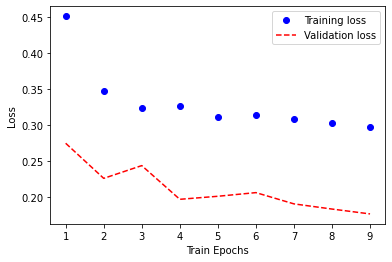

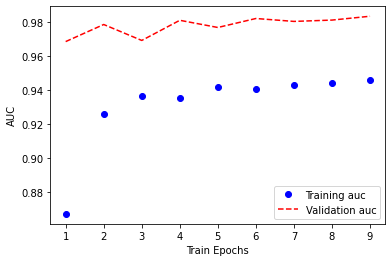

In [6]:
# inspect metrics
history_dict = history.history
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
auc = history_dict["auc"]
val_auc = history_dict["val_auc"]
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "r--", label="Validation loss")
plt.xlabel("Train Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(epochs, auc, "bo", label="Training auc")
plt.plot(epochs, val_auc, "r--", label="Validation auc")
plt.xlabel("Train Epochs")
plt.ylabel("AUC")
plt.legend()
plt.show()

In [7]:
n = 5
s = 100

p = model.predict(x_val[:1000,:])[:, 0]

scores = eg.get_scores(x_val[:1000,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:1000,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

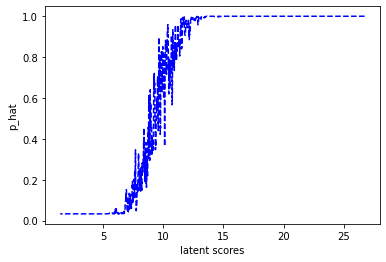

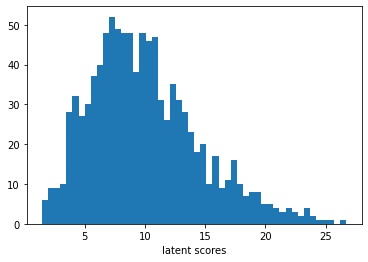

In [8]:
plt.plot(scores, p, '--b')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

plt.hist(scores, bins=50)
plt.xlabel('latent scores')
plt.show()

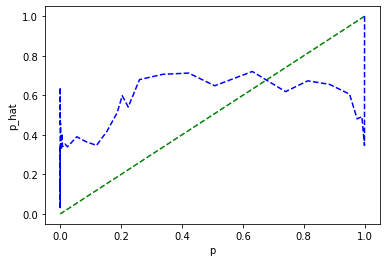

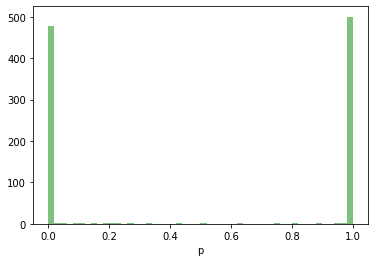

In [9]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

plt.hist(probs, bins=50, color='g', alpha=0.5)
plt.xlabel('p')
plt.show()

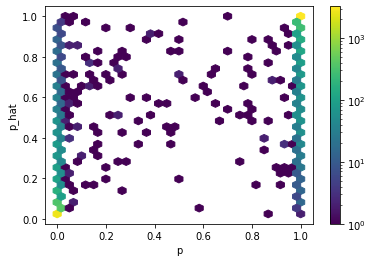

In [10]:
n = 1
s = 100

p = model.predict(x_val[:10000,:])[:, 0]

scores = eg.get_scores(x_val[:10000,:])

probs = eg.get_probabilities(x_val[:10000,:])[1]

plt.hexbin(probs, p, gridsize=30, bins='log')
plt.colorbar()
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

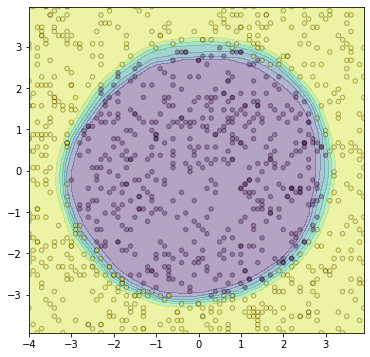

In [11]:
# Plot decision regions
I, J = 2, 6
x_min, x_max = x_val[:, I].min(), x_val[:, I].max()
y_min, y_max = x_val[:, J].min(), x_val[:, J].max()
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
xxyy = np.c_[xx.ravel(), yy.ravel()]
x_ = np.zeros((xxyy.shape[0], 10))
x_[:, I] = xxyy[:, 0]
x_[:, J] = xxyy[:, 1]
z = model.predict(x_)
z = z.reshape(xx.shape)
y_ = eg.get_labels(x_)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.contourf(xx, yy, z, alpha=0.4)
ixs = np.random.randint(0, y_.shape[0]-1, 1000)
ax.scatter(x_[ixs, I], x_[ixs, J], c=y_[ixs], s=20, alpha=0.3, edgecolor="k")
plt.show()

#model.summary()

In [12]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_96 (Dense)            (None, 60)                660       
                                                                 
 dropout_72 (Dropout)        (None, 60)                0         
                                                                 
 dense_97 (Dense)            (None, 60)                3660      
                                                                 
 dropout_73 (Dropout)        (None, 60)                0         
                                                                 
 dense_98 (Dense)            (None, 60)                3660      
                                                                 
 dropout_74 (Dropout)        (None, 60)                0         
                                                                 
 dense_99 (Dense)            (None, 1)               

In [13]:
champion_params

{'learning_rate': 0.004,
 'batch': 8,
 'epoch': 10,
 'optimizer': 'rmsprop',
 'best_loss': {'loss': 0.16466748714447021, 'epoch': 9},
 'best_auc': {'auc': 0.9865249395370483, 'epoch': 9},
 'best_accuracy': {'accuracy': 0.9346500039100647, 'epoch': 9},
 'model': <keras.engine.sequential.Sequential at 0x7fb82660f190>}

In [14]:
scan_results

[{'learning_rate': 2.4e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.24926544725894928, 'epoch': 394},
  'best_auc': {'auc': 0.9926930665969849, 'epoch': 394},
  'best_accuracy': {'accuracy': 0.900950014591217, 'epoch': 242}},
 {'learning_rate': 3e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.25134792923927307, 'epoch': 278},
  'best_auc': {'auc': 0.9919414520263672, 'epoch': 388},
  'best_accuracy': {'accuracy': 0.8985999822616577, 'epoch': 204}},
 {'learning_rate': 3.6e-05,
  'batch': 256,
  'epoch': 280,
  'optimizer': 'nadam',
  'best_loss': {'loss': 0.25315409898757935, 'epoch': 210},
  'best_auc': {'auc': 0.9920873641967773, 'epoch': 381},
  'best_accuracy': {'accuracy': 0.8959500193595886, 'epoch': 133}},
 {'learning_rate': 0.004,
  'batch': 256,
  'epoch': 590,
  'optimizer': 'sgd',
  'best_loss': {'loss': 0.2287212461233139, 'epoch': 577},
  'best_auc': {'auc': 0.9936923980712891, 'epoch': 736},


### Tuning notes: 

Data: train 100096 / val 20000

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 80/80 **val_loss: 0.4221** - val_accuracy: 0.7657 - val_auc: 0.9857

--
* model: 30, 0.25, 30, 0.25, 30, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 60/80 **val_loss: 0.3241** - val_accuracy: 0.8463 - val_auc: 0.9856

--
* model: 40, 0.25, 40, 0.25, 40, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 40/80 **val_loss: 0.2726** - val_accuracy: 0.8848 - val_auc: 0.9889

--
* model: 50, 0.25, 50, 0.25, 50, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 38/80 **val_loss: 0.2555** - val_accuracy: 0.8832 - val_auc: 0.9916

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 3e-5
* Epoch: 28/80 **val_loss: 0.2552** - val_accuracy: 0.8909 - val_auc: 0.9929

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 48/80 **0.2557** - val_accuracy: 0.8771 - val_auc: 0.9935

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 20, 0.25, 6, 0.25, 1/ batch: 256 / Nadam lr: 2e-5
* Epoch: 47/80 **0.3482** - val_accuracy: 0.8346 - val_auc: 0.9910

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 5e-3
* Epoch: 59/80 **0.2176** - val_accuracy: 0.8953 - val_auc: 0.9961

--
* model: 60, 0.25, 60, 0.25, 60, 0.25, 1/ batch: 256 / SGD lr: 3e-3
* Epoch: 80/100 **0.2205** - val_accuracy: 0.8970 - val_auc: 0.9951

--
8/1e-2=> 0.2021 - val_accuracy: 0.9207 - val_auc: 0.9904
8/8e-3=> 0.26...
8/1.3e-2=> 0.25